<a href="https://colab.research.google.com/github/allen44/endo-us-econ-analysis/blob/main/forecasting_gdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
US GDP data is released every three months. Is it possible to forecast the next GDP data release by using the data available from any source before then?

Many types of economic data are released monthly, and weekly. These data consist of numeric and non-numeric components. Using these publically available sources, this notebook will forecast the upcoming GDP release up to one quarter in the future.

# Background


## Research Review
The objective and the input data are similar to a [research paper published by the St Louis Fed in 2016.](https://research.stlouisfed.org/publications/review/2016/12/05/a-macroeconomic-news-index-for-constructing-nowcasts-of-u-s-real-gross-domestic-product-growth/) 

In this paper, the authors evaluate the usefulness of a three-way linear regression model in predicting GDP. 

>Analyzing the performance of the economy in real time is a challenge for those who must forecast macroeconomic variables such as inflation or employment. A key aspect of this challenge is evaluating the incoming flow of information contained in economic announcements. In this article, the authors develop a simple-to-read index of these announcements that they then use to construct nowcasts. The index tracks whether key economic data have come in stronger, weaker, or as expected during the current quarter relative to a baseline consensus forecast. Specifically, the data releases are weighted relative to their importance in updating forecasts of real gross domestic product growth during the current quarter.

The input data that I will use differs in that I will use NLP to process the non-numeric data in the economic data releases to create new features to use as input to a model.

## Data Selection Criteria

There are over 700 thousand economic data series that a readily accessible from the St. Louis Fed's API, and ten's of thousands more from other government and private sources. 

For this notebook, I selected a handful of 'classically important' economic measures that economist's have used for decades in predicting business cycles and guiding national economic policy. This selection process has two primary benefits:
1. These data series have been vetted by practictioner's with domain expertise and the literature shows them to be useful in a variety of contexts.
2. These data series have histories that span to multiple decades before the rise of Big Data; some series start in the 1940s and earlier.


#### Numerical Data
Most of the numerical data are aggregated from direct measures of economic activity (such as dollar of goods sold, or number of building permits issued). Other numerical data are aggregations of surveys completed by participents in the economy (such as the PMI index, or the GDP Nowcast).

## Todo List:
1. Scrape the text data from the PMI and NMI releases.
2. Approriately process the text data with nltk, GenSim, or similar.
3. Perform baseline modelling to choose a set of models to tune further.
4. Write up 
  * Exploration - talk about the important features
  * 3 important one, 3 non important ones
  * bivariate chart showing relation between them
  * show distributions
  * EDA: group categories with high-ratio and low-ratio, instead of having hundreds of categories.
  * Wrangling- describe manipulation and data changes
  * Methods
  * Make a plot n_sample for training, as a function of performance on the validation (always use the same test set). Look for a convergence of the performance after reaching sufficne samples. Use the best hyperparameters, not a grid search. (Try decision tree first, because it's fast.
  * discussion on each model, with summary of advs and disadvs of each model, assumptions
  * Most important  is to describe shortcomings of the data and analysis-room for improvement. Weaknesses/ limitations in the model. Show readers where the model and analysis can be improved.
  * Explain the choices made in the analysis
  * statistical tests of significance
  * Show chart with final perf on test set


## Completed list:
1. Gather and preprocess numerical data from Fed and Quandl.
2. Perform baseline modelling on the numerical data only.
* id important features have strong variation  with target var

# Imports

## Modules

### Mount the GDrive storage

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


### Clone the Github repository into GDrive

In [2]:
# ! git clone https://github.com/allen44/endo-us-econ-analysis

In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis'

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [4]:
! ls

contractions.py  model_evaluation_utils.py  __pycache__
csv.csv		 models			    requirements.txt
cv_results	 news_cache.sqlite	    us_econ_analysis.sqlite
data		 preds


In [5]:
! pip install -r requirements.txt
! pip install icecream
# After installing, restart the Colab runtime so that modules that were unistalled and then reinstalled will be handled correctly.
# If skipped, the most common error is a Pandas error upon collecting the data.

In [6]:
# Set api key variables
% cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! cd "/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis"
! export PATH=$PATH:'/content/drive/MyDrive/Colab Notebooks/API Keys'

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')

import config
API_KEY = config.API_KEY


from pathlib import Path
working_path = Path('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis')

/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis


In [7]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from icecream import ic

## Data Sources



### Numeric data from FRED and Quandl

In [8]:
data_series_ids = {
    'fred': {
        # GDP
        'A191RP1Q027SBEA': 'gdp_growth', # Target: GDP Growth, Percent Change from Preceding Period, Seasonally Adjusted Annual Rate
        'GDPC1': 'GDPC1', # Real Gross Domestic Product, chained 2012 dollars, for calculations later
        'GDP': 'GDP', # Gross Domestic Product (GDP), Units: Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
        # Plotting helper
        'USRECD': 'is_recession', # NBER Recession indicator, retrospective only (not for forecasting)
        # Money Supply
        'WM2NS': 'M2', # M2 Money Stock, weekly, not seasonally adjusted
        # Interest Rates, 
        'FEDFUNDS': 'IR', # IR% : Effective Federal Funds Rate, monthly
        'T10YFF': 'IR_spread', # Interest rate spread (10-year Treasury vs. Effective Federal Funds Rate), Percent, Not Seasonally Adjusted, Daily
        # Inflation: Consumer and Business Inflation 
        'CPIAUCSL': 'CPI',  # CPI: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
        'CPILFESL': 'CPI_Core', # CPI Core: Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average
        'WPSFD49207': 'PPI', # PPI: Producer Price Index by Commodity: Final Demand: Finished Goods, Monthly
        'WPSFD4131': 'PPI_Core', # PPI Core: Producer Price Index by Commodity: Final Demand: Finished Goods Less Foods and Energy, Monthly
        # Employment
        # Employemnt Situation Report: http://data.bls.gov/pdq/SurveyOutputServlet?request_action=wh&graph_name=CE_cesbref1 
        'PAYEMS': 'employment', # All Employees, Total Nonfarm, Monthly
        'ICSA': 'initial_claims', # Average weekly initial jobless claims for unemployment insurance, Number, Seasonally Adjusted, Weekly
        'AWHMAN': 'weekly_hours', # Average Weekly Hours of Production and Nonsupervisory Employees, Manufacturing, Hours, Seasonally Adjusted, Monthly
        # Balance Sheets and Sovereign Risk
        'GFDEGDQ188S': 'debt_as_pct_of_gdp', # Federal Debt: Total Public Debt as Percent of GDP, Seasonally Adjusted
        'FYFSDFYGDP': 'surplus_or_deficit_as_pct_of_gdp', # Federal Surplus or Deficit [-] as Percent of GDP
        'FYOIGDA188S': 'interest_payments_as_pct_of_gdp', # Federal Outlays: Interest as Percent of GDP, annual
        'WGS10YR': '10_year_rates', # 10-Year Treasury Constant Maturity Rate
        'W018RC1Q027SBEA': 'total_receipts', # Federal government total receipts, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
        # 'W019RCQ027SBEA': 'total_expenditures',
        'A091RC1Q027SBEA': 'interest_payments', # Federal government current expenditures: Interest payments, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
        'WALCL': 'central_bank_total_assets', #  CB Balance Sheet: Assets: Total Assets: Total Assets (Less Eliminations from Consolidation): Wednesday Level, Units: Millions of U.S. Dollars, Not Seasonally Adjusted
        'STLENI': 'gdp_growth_nowcast',  # St Louis Fed's Real GDP Nowcast, Percent Change at Annual Rate, Seasonally Adjusted Annual Rate, Quarterly
        # Other classically leading indicators of gdp
        'UMCSENT': 'michigan_consumer_sentiment',  # Michigan sentiment survey index
        'PERMIT': 'building_permits', # New housing construction building  permits issued, monthly, seasonally adjusted annualized rate.
        'NEWORDER': 'new_orders_non_defense', # Manufacturers' New Orders: Nondefense Capital Goods Excluding Aircraft, Millions of Dollars, Seasonally Adjusted, Monthly
        }, 
    'quandl': {
        'ISM/MAN_PMI': 'PMI',
        'ISM/MAN_NEWORDERS': 'PMI_new_orders',
        'ISM/MAN_DELIV': 'PMI_deliv',
        # 'ISM/MAN_CUSTINV': 'PMI_custinv',
        # 'ISM/MAN_PRICES': 'PMI_prices',
        # 'ISM/MAN_EMPL': 'PMI_empl',
        # 'ISM/MAN_BACKLOG': 'PMI_backlog',
        # 'ISM/MAN_PROD': 'PMI_prod',
        # 'ISM/MAN_EXPORTS': 'PMI_exports',
        # 'ISM/MAN_INVENT': 'PMI_inventory',
        # 'ISM/MAN_IMPORTS': 'PMI_imports',
        # 'ISM/BUY_PROD_MAT': 'PMI_prod_mat',
        # 'ISM/BUY_MRO_SUPP': 'PMI_mro_supp',
        # 'ISM/BUY_CAP_EXP': 'PMI_cap_exp',
        'ISM/NONMAN_NMI': 'NMI',
        # 'ISM/NONMAN_BUSACT': 'NMI_bus_act',
        # 'ISM/NONMAN_EMPL': 'NMI_empl',
        'ISM/NONMAN_NEWORD': 'NMI_new_orders',
        # 'ISM/NONMAN_DELIV': 'NMI_deliv',
        # 'ISM/NONMAN_EXPORTS': 'NMI_exports',
        # 'ISM/NONMAN_INVENT': 'NMI_inventory',
        # 'ISM/NONMAN_BACKLOG': 'NMI_backlog',
        # 'ISM/NONMAN_IMPORTS': 'NMI_imports',
        # 'ISM/NONMAN_PRICES': 'NMI_prices',
        # 'ISM/NONMAN_INVSENT': 'NMI_invsent',
        }
  }
                      
# Group data series by frequency
series_by_freqs = {'W': ['M2',
                         '10_year_rates',
                         'IR_spread',
                         'central_bank_total_assets_as_pct_of_gdp',
                         'initial_claims',
                         'SP500'],
                   'M': ['IR',
                       'CPI',
                       'CPI_Core',
                       'PPI',
                       'PPI_Core',
                       'employment',
                       'weekly_hours',
                       'building_permits',
                       'PMI',
                       'NMI',
                       'michigan_consumer_sentiment',
                       'new_orders_non_defense'],
                   'Q': ['debt_as_pct_of_gdp',
                         'surplus_or_deficit_as_pct_of_gdp',
                         'liquidity_cover_ratio',
                         ],
                   'Y': ['interest_payments_as_pct_of_gdp']}

In [9]:
import pandas_datareader as pdr
import datetime
import quandl
import datetime
import requests_cache

# Get data from FRED
expire_after = datetime.timedelta(days=7)
session = requests_cache.CachedSession(cache_name='us_econ_analysis', expire_after=expire_after)
start = datetime.datetime(1947, 4, 1)
end = datetime.datetime.today()

series_id_list = data_series_ids['fred'].keys()
params = {
    'api_key': API_KEY['fred'],
    'limit': 100000,
                }
df = pdr.fred.FredReader(series_id_list, 
                          start, end, 
                          session=session).read()
df.index = df.index.rename('date')

# Rename series with descriptive names
df = df.rename(columns=data_series_ids['fred'])

# Resample daily data to weekly
df['IR_spread'] = df['IR_spread'].resample('W').last()

# Calculate useful ratios then drop raw data
df['liquidity_cover_ratio'] = (df['total_receipts'] / 
                               (df['interest_payments'].fillna(method='ffill')))

df['central_bank_total_assets_as_pct_of_gdp'] = (df['central_bank_total_assets']/1000 / #Convert to Billions from Millions
                                                 (df['GDP'].fillna(method='ffill')) * 100)  # already in Billions

df['interest_payments_as_pct_of_gdp'] = df['interest_payments']/df['GDP']
df = df.drop(columns=['total_receipts',
                      'interest_payments',
                      # 'total_expenditures',
                      'central_bank_total_assets',
                      'GDP',
                      'GDPC1'])
# Plotting helpers
df['is_recession'] = df['is_recession'].astype(bool)

# Data from a second data source, Quandl
quandl.ApiConfig.api_key = API_KEY['quandl']

q_df_s = {}
for series_id in data_series_ids['quandl']:
  temp_df = quandl.get(series_id) # Returns a dataframe
  if len(temp_df.columns)==1:
    # Rename series with descriptive names
    temp_series = temp_df.squeeze().rename(data_series_ids['quandl'][series_id])
    q_df_s[series_id] = temp_series
  else:
    if 'Index' in temp_df.columns:
      temp_series = temp_df['Index'].rename(data_series_ids['quandl'][series_id])
      q_df_s[series_id] = temp_series
    elif 'Diffusion Index' in temp_df.columns:
      temp_series = temp_df['Diffusion Index'].rename(data_series_ids['quandl'][series_id])
      q_df_s[series_id] = temp_series
    else:
      temp_series = temp_df.add_prefix(data_series_ids['quandl'][series_id])
      q_df_s[series_id] = temp_series
q = pd.concat(list(q_df_s.values()), axis=1)
df = df.join(q, how='outer')
df.index = df.index.rename('date')

# Get data from third source: Stooq, for weekly SP500 data
df['SP500'] = pdr.data.DataReader('^SPX', 'stooq', start=start, end=end, session=session)['Close'].resample('W').last()

In [10]:
df.fillna(method='ffill')

,gdp_growth,is_recession,M2,IR,IR_spread,CPI,CPI_Core,PPI,PPI_Core,employment,initial_claims,weekly_hours,debt_as_pct_of_gdp,surplus_or_deficit_as_pct_of_gdp,interest_payments_as_pct_of_gdp,10_year_rates,gdp_growth_nowcast,michigan_consumer_sentiment,building_permits,new_orders_non_defense,liquidity_cover_ratio,central_bank_total_assets_as_pct_of_gdp,PMI,PMI_new_orders,PMI_deliv,NMI,NMI_new_orders,SP500
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1947-04-01,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-02,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-03,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-04,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-05,4.7,False,NaN,NaN,NaN,22.000,NaN,26.0,NaN,43499.0,NaN,40.5,NaN,NaN,0.021791,NaN,NaN,NaN,NaN,NaN,8.059515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,11.0,True,20256.0,0.06,1.41,268.551,275.718,217.2,216.0,144894.0,412000.0,41.6,127.52159,-4.6399,0.024011,1.50,9.3,88.3,1681.0,74938.0,7.331581,36.554317,61.2,67.0,78.8,64.0,63.9,4247.44
2021-06-17,11.0,True,20256.0,0.06,1.41,268.551,275.718,217.2,216.0,144894.0,412000.0,41.6,127.52159,-4.6399,0.024011,1.50,9.3,88.3,1681.0,74938.0,7.331581,36.554317,61.2,67.0,78.8,64.0,63.9,4247.44
2021-06-18,11.0,True,20256.0,0.06,1.41,268.551,275.718,217.2,216.0,144894.0,412000.0,41.6,127.52159,-4.6399,0.024011,1.51,9.3,88.3,1681.0,74938.0,7.331581,36.554317,61.2,67.0,78.8,64.0,63.9,4247.44


# EDA

## Numerical Data

### Visually check the unprocessed data

In [11]:
# Plotting functions

def plot_subset_together(subset: list, ref_line=0):
  ax = sns.histplot(df[subset])
  if type(ref_line) != None:
    ax.axvline(ref_line, color='grey', linestyle='--')

def plot_subset(subset: list, ref_line=0):
  plt.rcParams.update({'figure.max_open_warning': 0})
  for col in subset:
    try:
      fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
      sns.scatterplot(data=df, x='date', y=col, ax=axes[0], hue='is_recession')
      sns.histplot(data=df, y=col, hue='is_recession', ax=axes[1])
      sns.boxplot(data=df, y=col, x='is_recession', ax=axes[2])
      if type(ref_line) != type(None):
        mean = df[col].mean()
        std = df[col].std()
        # if refline is within the 3*std of mean
        if (mean + 3*std > ref_line) and (mean - 3*std < ref_line):
          for ax in axes:
            ax.axhline(ref_line, color='grey', linestyle='--')
      plt.tight_layout()
    except ValueError as e:
      print(f'Error while plotting {col}')
      print(e)

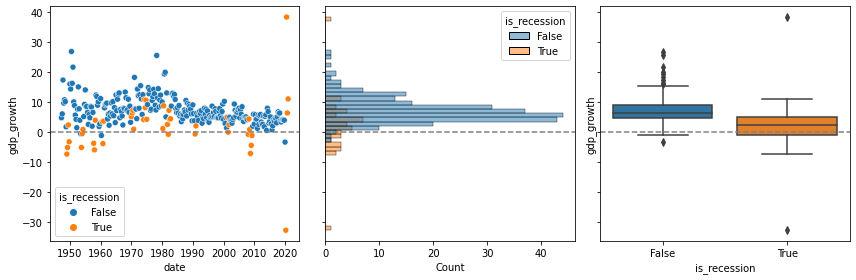

In [12]:
plot_subset(['gdp_growth'])

We see that the target variable appears stationary and fairly well-behaved for modeling.

[Text(0.5, 1.0, 'Number of days during recession vs number of days not in recession')]

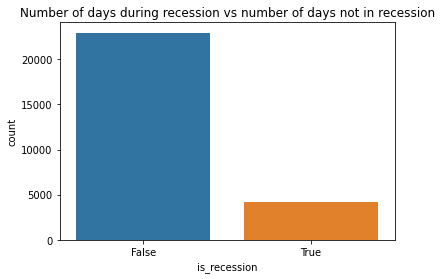

In [13]:
g= sns.countplot(x=df['is_recession'])
g.set(title='Number of days during recession vs number of days not in recession')

The minority of days are during recessions. Note that we only use this feature for plotting, not modeling. The definition of this data series states that it is a retrospective series.

In [14]:
unprocessed_subset = df.drop(columns=['gdp_growth', 'is_recession']).columns

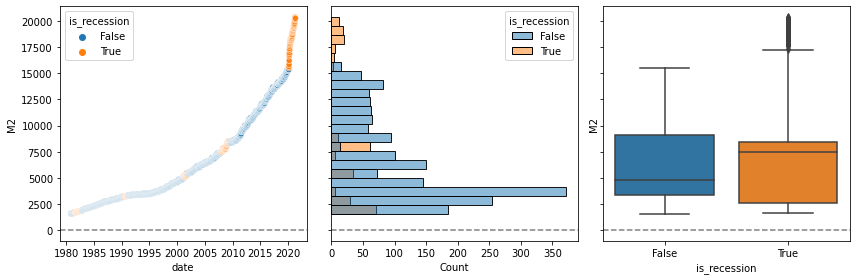

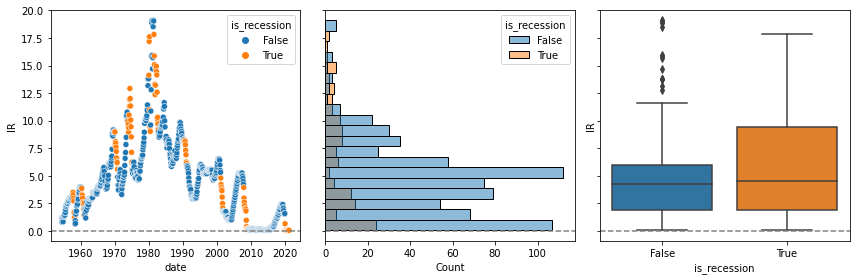

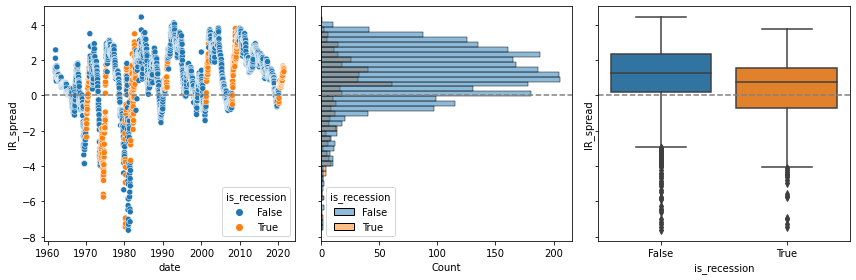

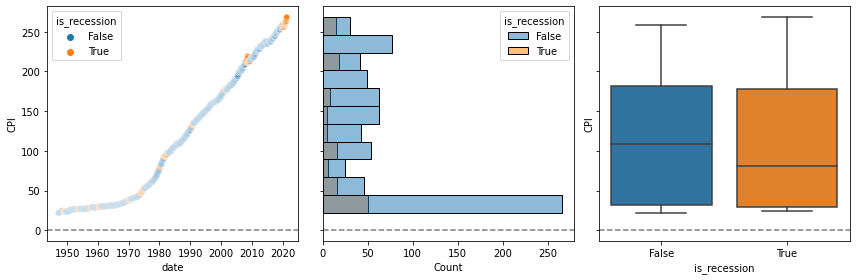

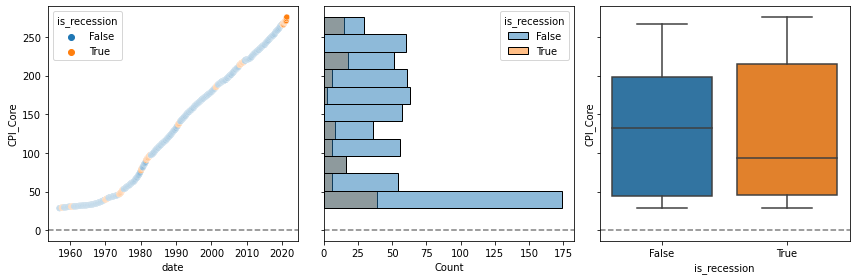

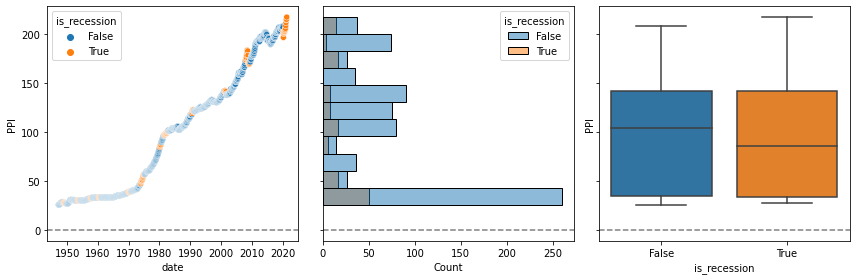

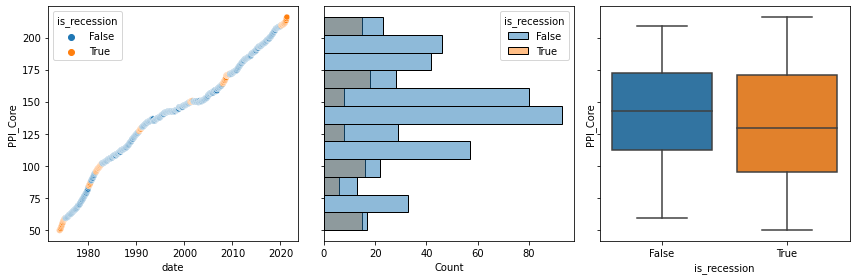

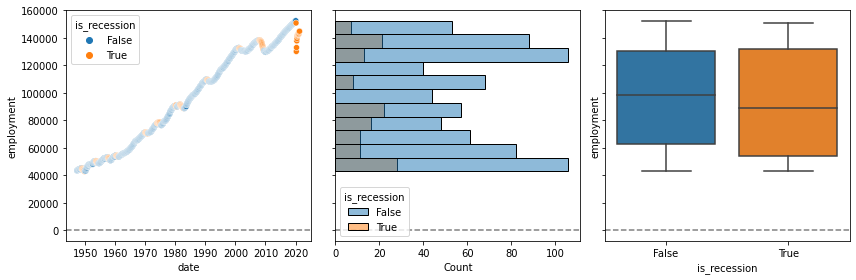

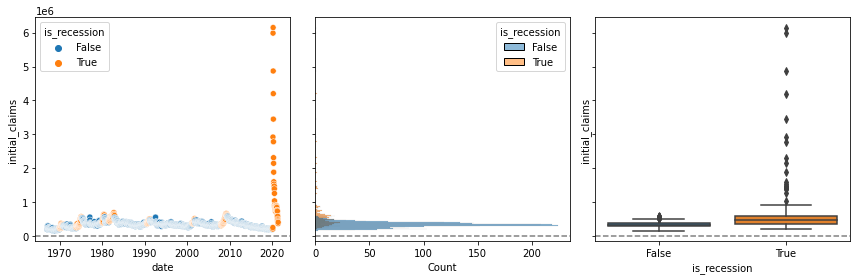

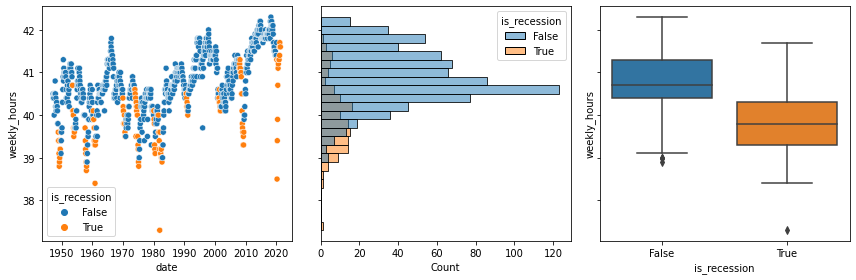

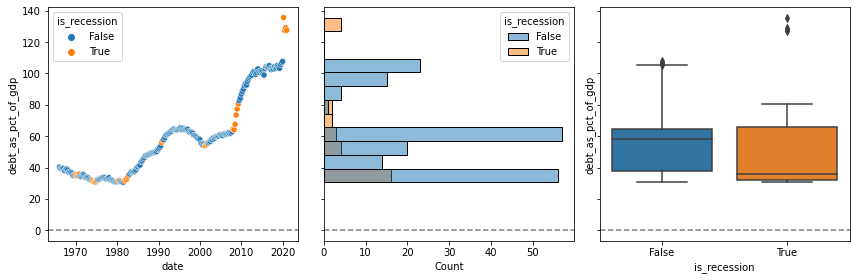

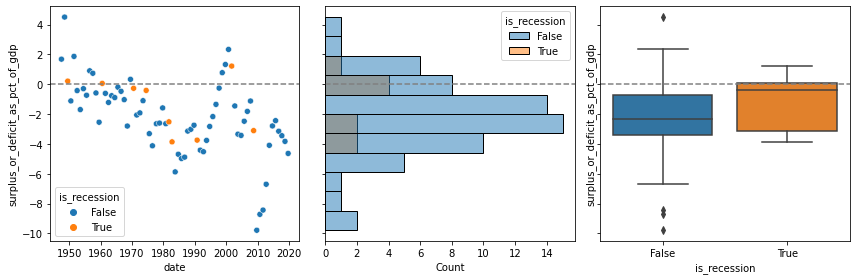

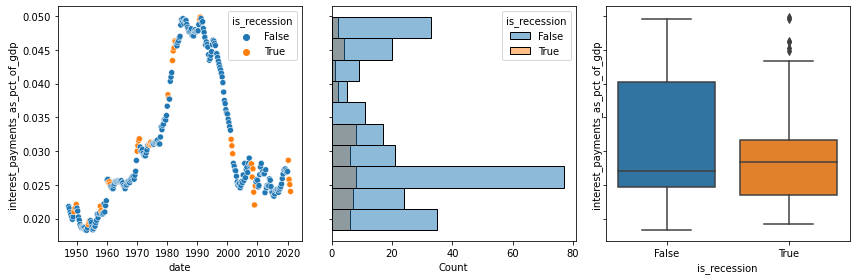

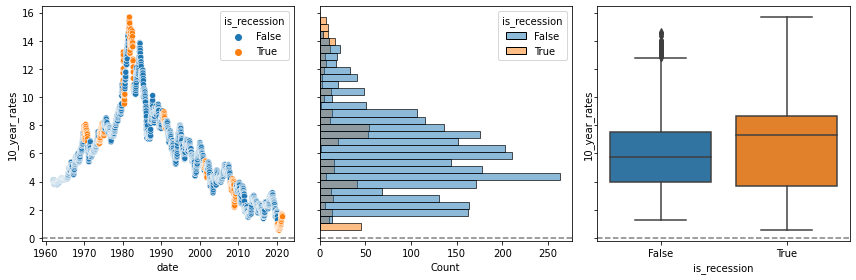

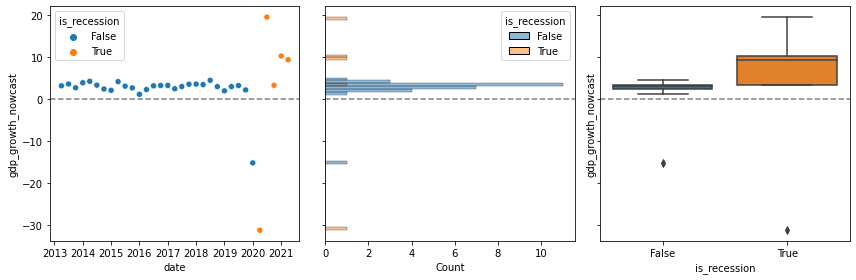

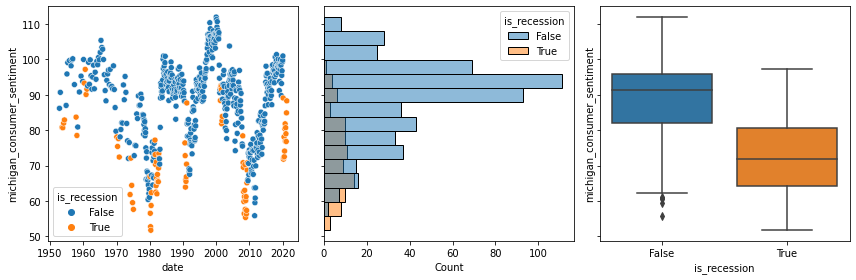

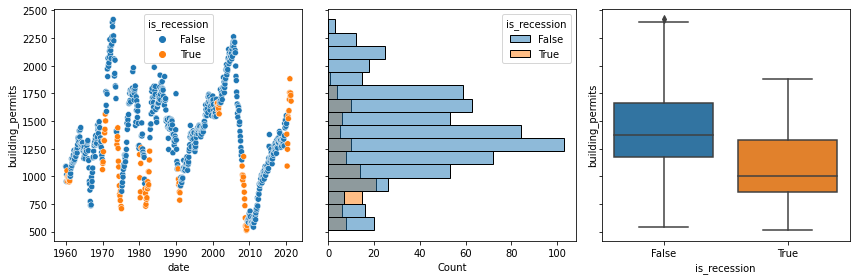

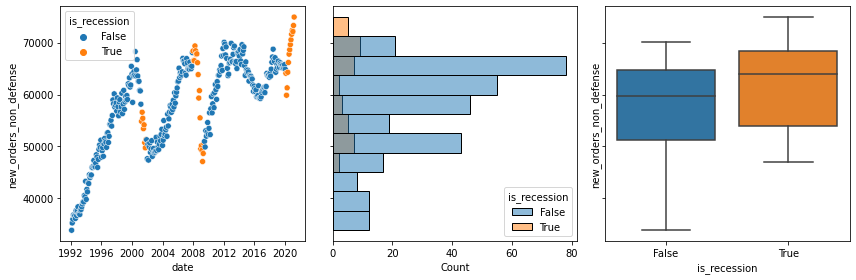

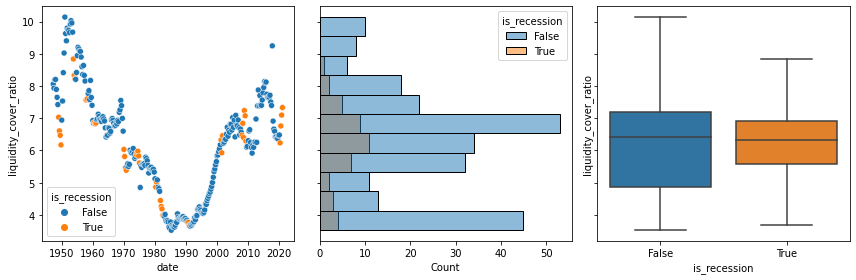

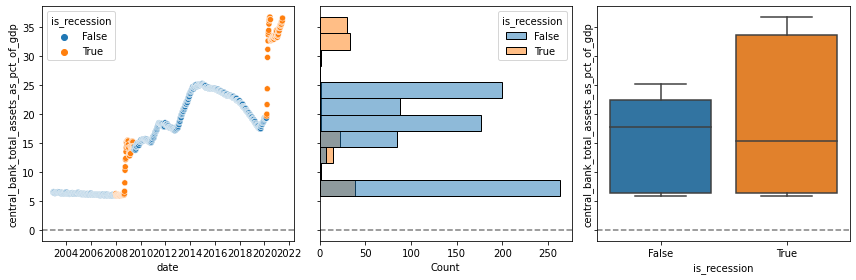

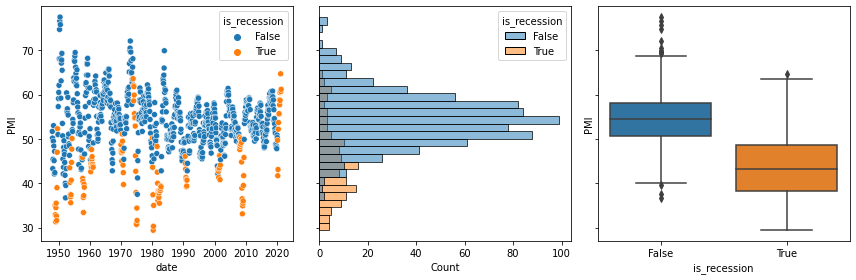

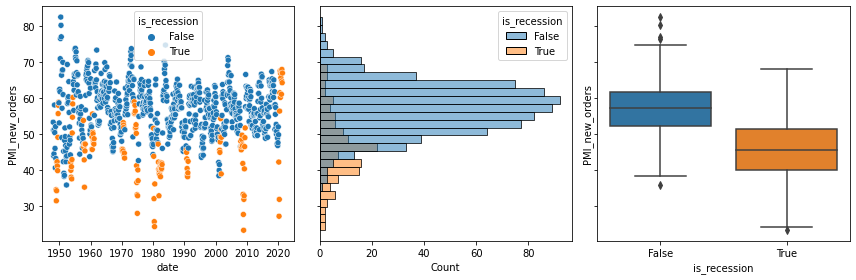

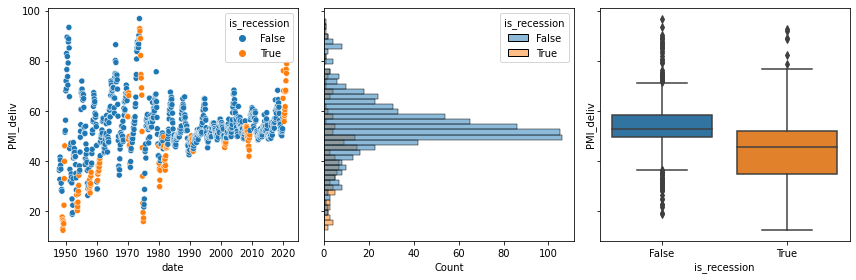

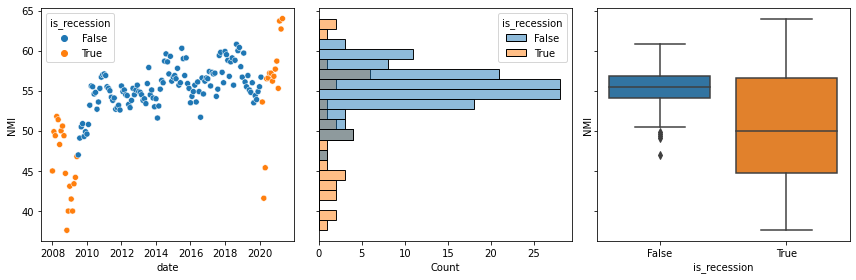

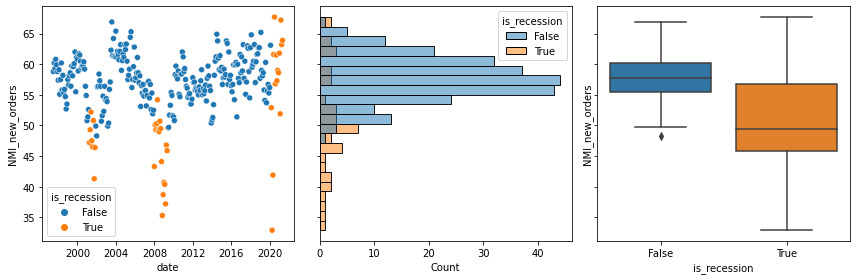

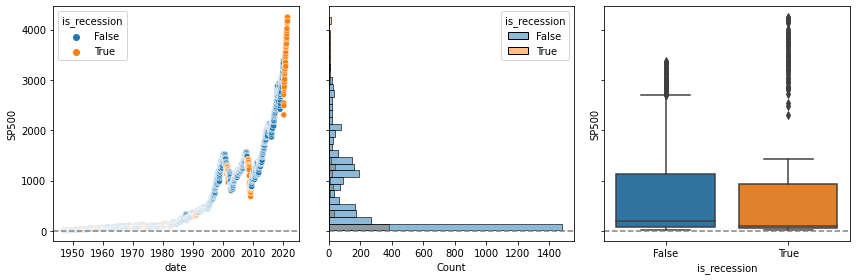

In [15]:
plot_subset(unprocessed_subset);

Most of the unprocessed series are not stationary, and require further processing before being useful in most models. 

## Textual Data

# Feature Engineering

## Numerical Data

### Manual Feature engineering

#### Derive about 50 new features from the original features

Calculate the percent change for features where that would make sense.

In [16]:
# Calculate pct_changes in weekly and monthly data
switch = {'W': [1, 2, 3, 4, 8, 13, 26],
          'M': [1, 2, 3, 4, 5, 6],
          'Q': [1, 2],
          'Y': [1]} 

new_features_subset = []
for freq, series_list in series_by_freqs.items():
  periods = switch[freq]
  for series in series_list:
    for period in periods:
      col_name = f'{series}_{period}{freq}_pct_change'
      new_features_subset.append(col_name)
      df[col_name] = df[series].dropna().pct_change(periods=period).dropna()*100
    # df = df.drop(columns=[series])
print(f'Created {len(new_features_subset)} new features.')

Created 121 new features.


#### Visually Check the Derived Data Series

28
Error while plotting IR_spread_1W_pct_change
autodetected range of [-inf, inf] is not finite
Error while plotting IR_spread_13W_pct_change
autodetected range of [-inf, inf] is not finite


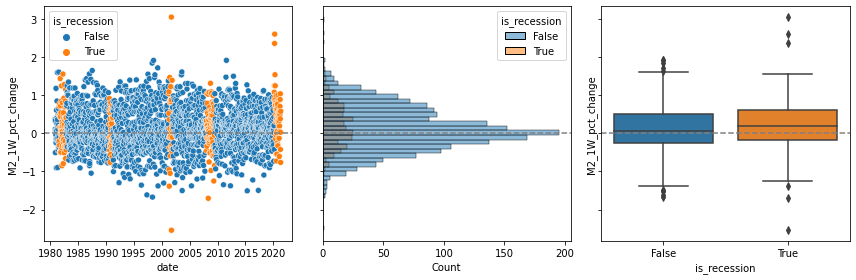

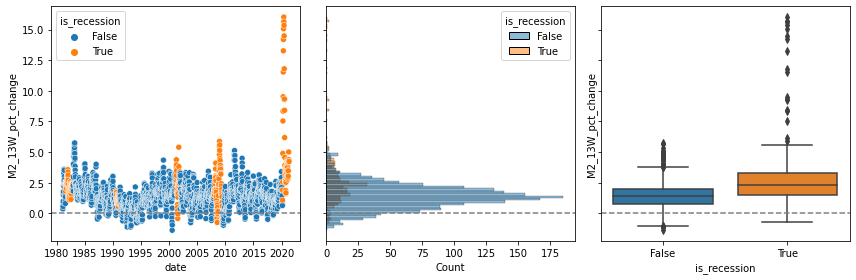

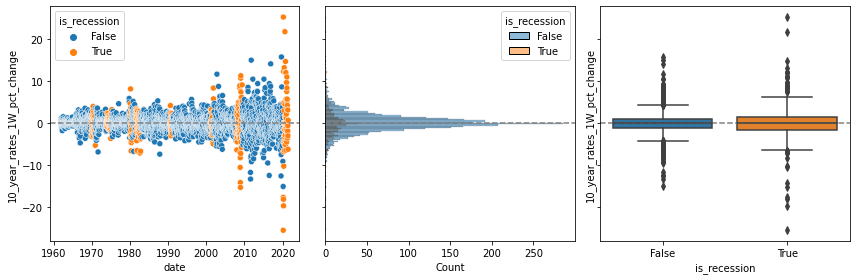

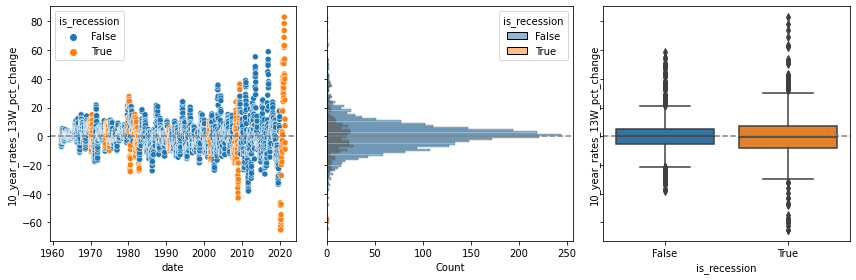

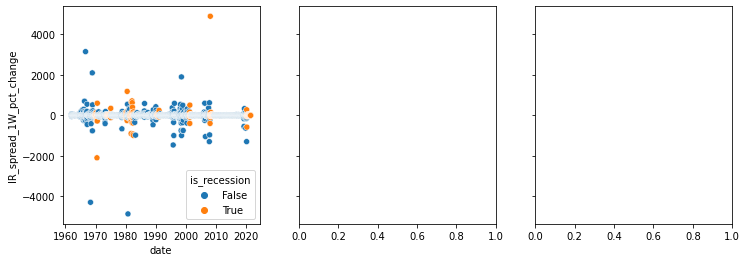

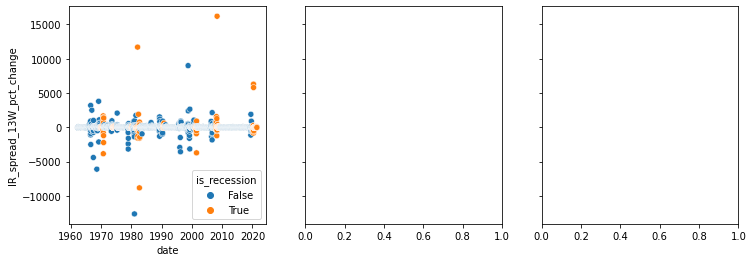

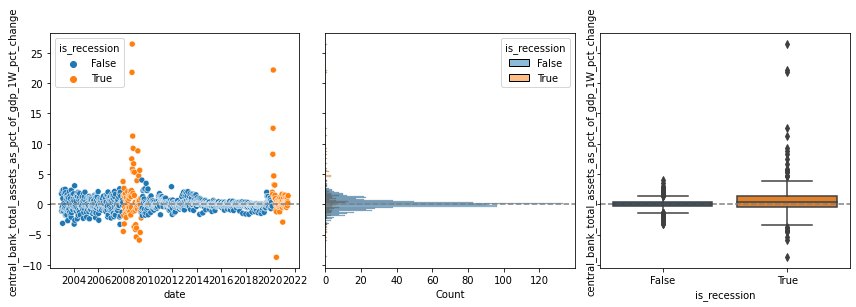

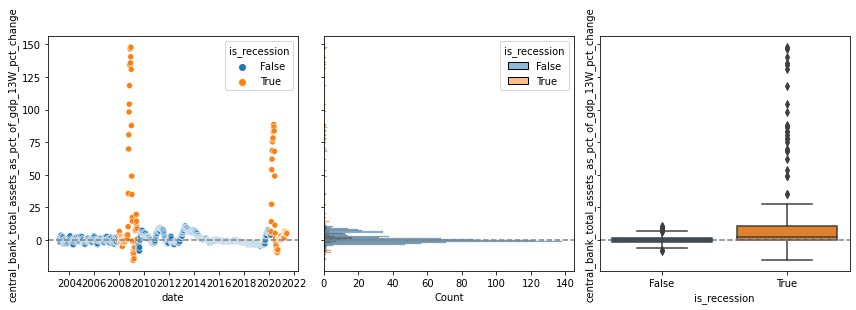

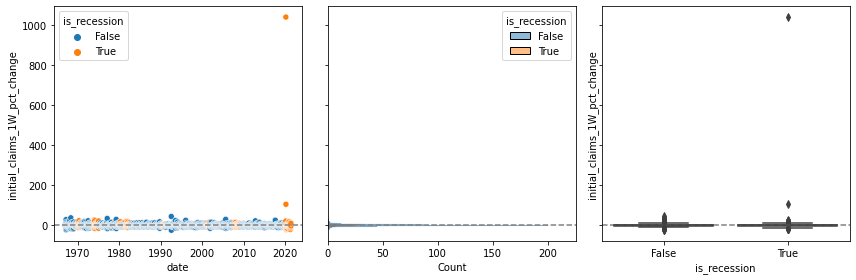

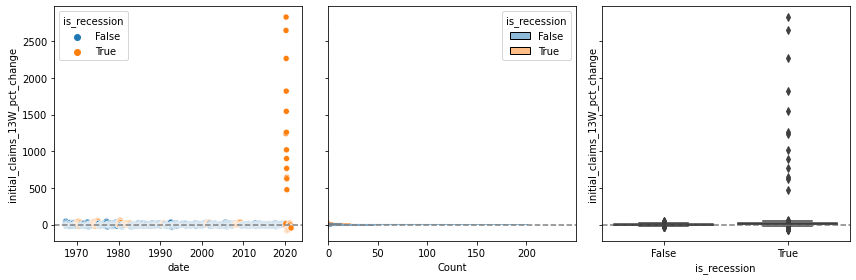

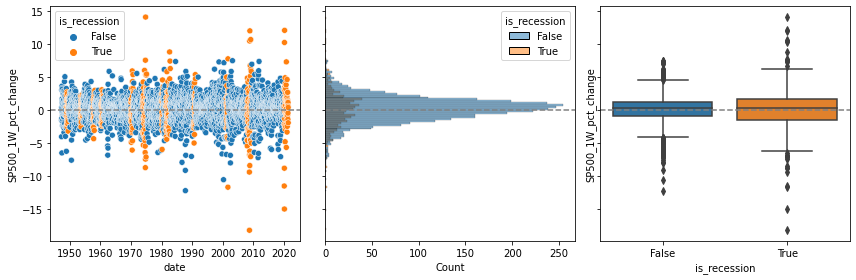

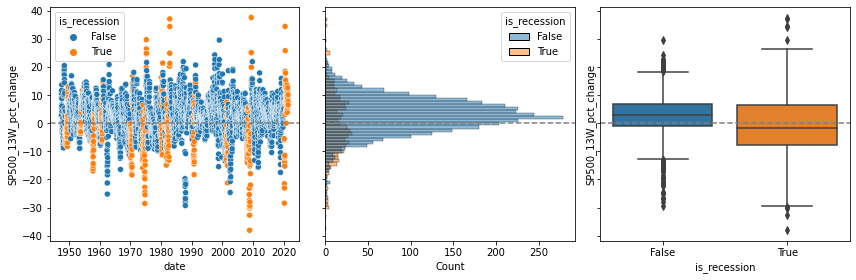

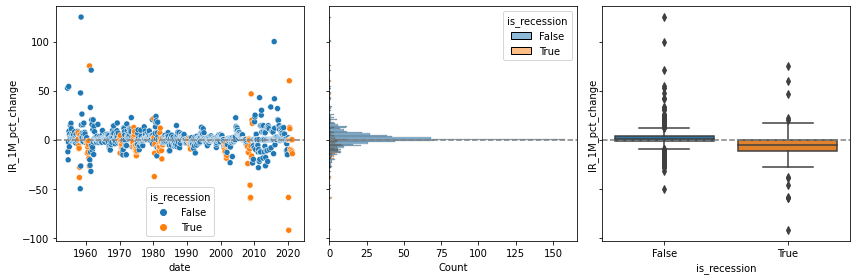

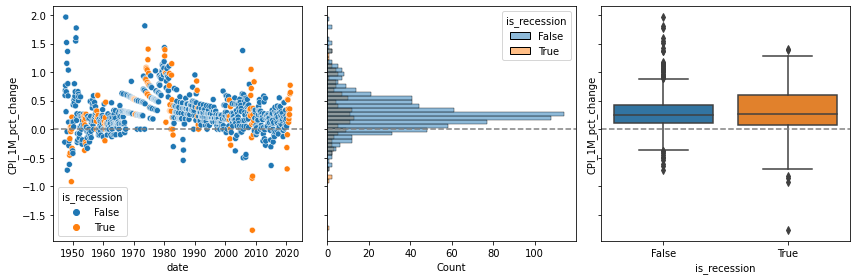

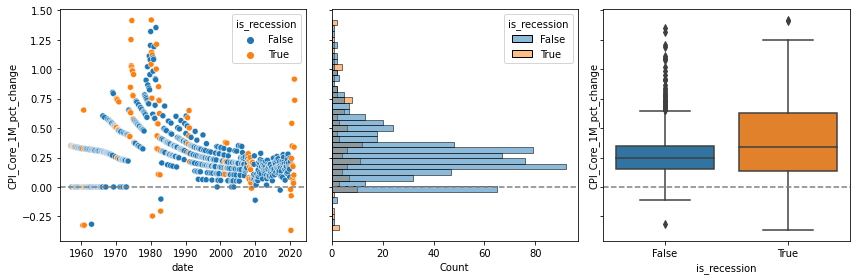

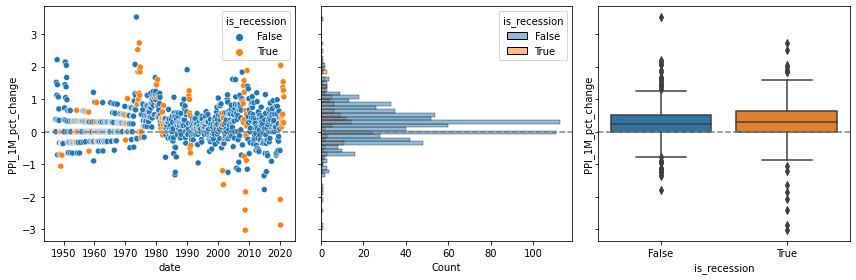

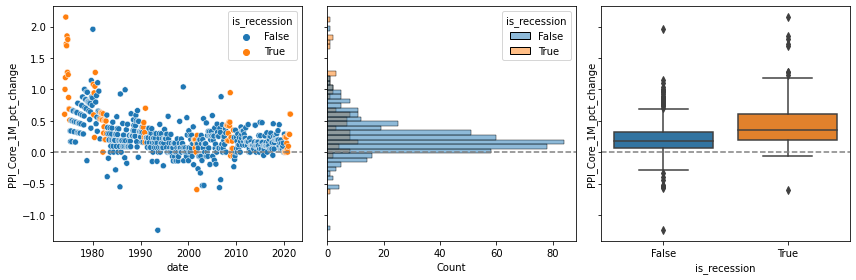

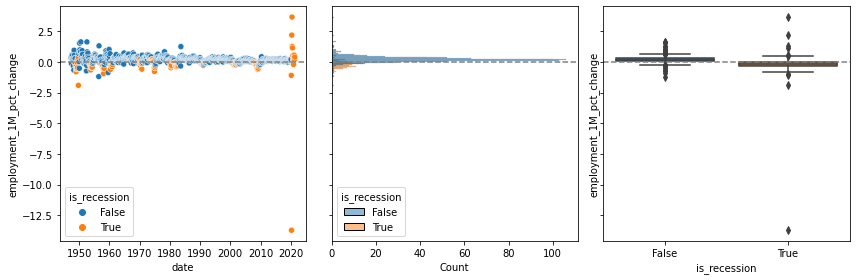

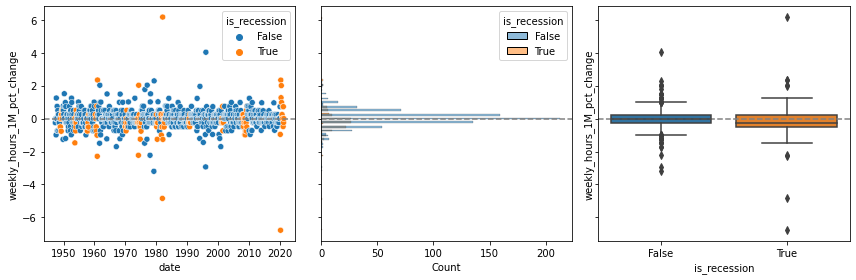

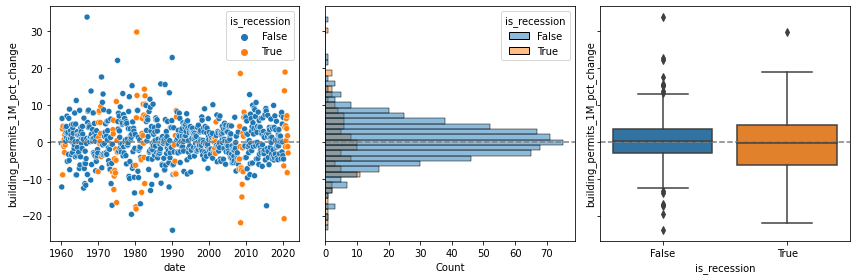

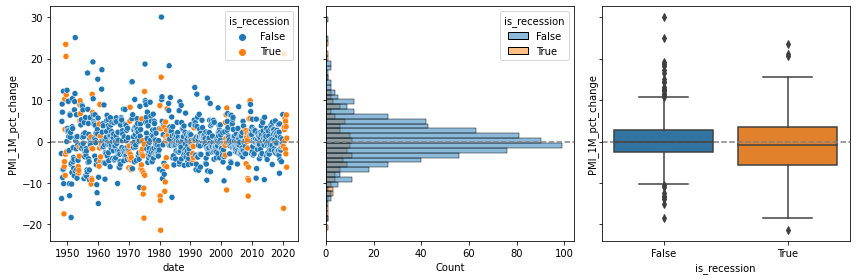

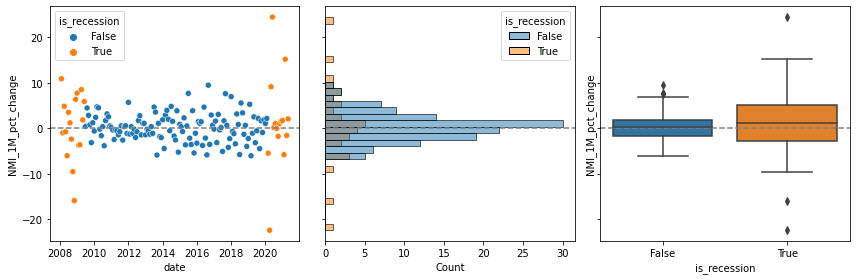

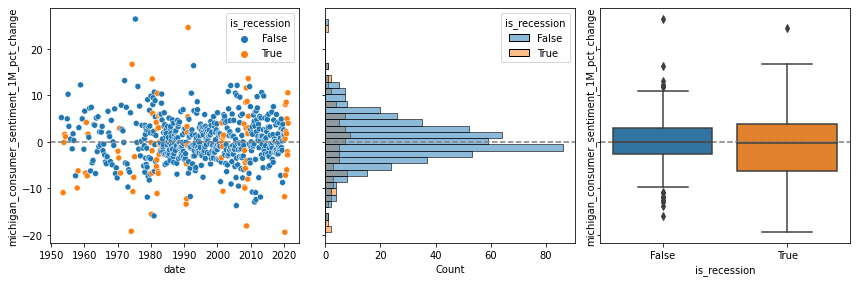

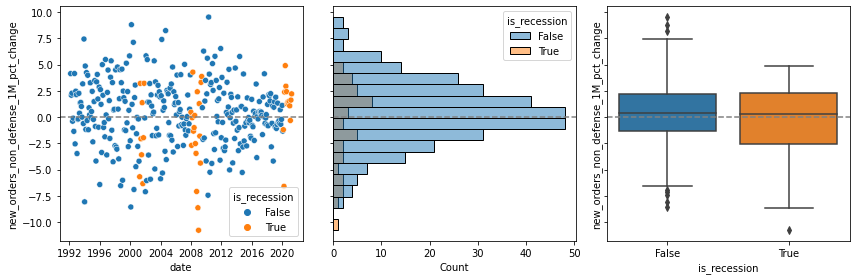

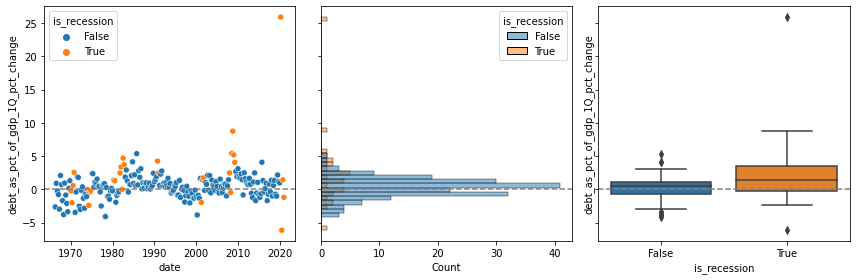

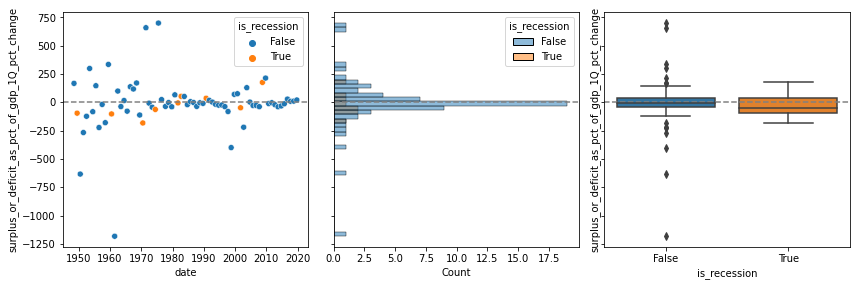

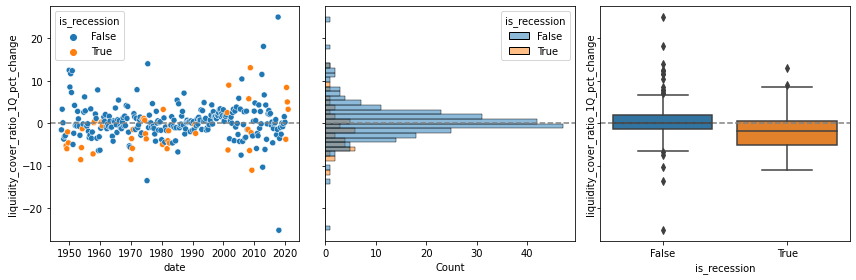

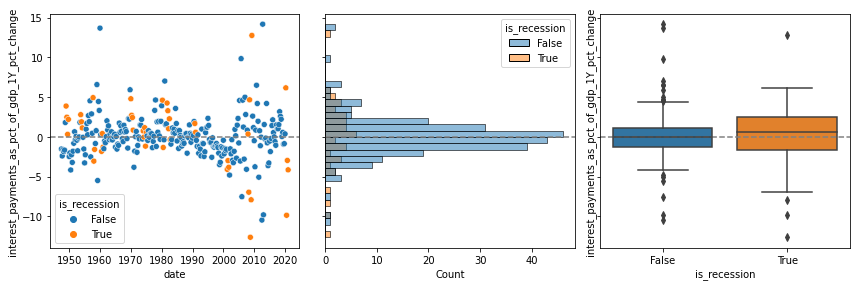

In [17]:
sample_new_columns = df[new_features_subset].filter(like='_1', axis=1).columns
print(len(sample_new_columns))
plot_subset(sample_new_columns)

### Automated Feature Engineering using tsfresh

#### Auto-generate over 14000 new features

In [18]:
from tsfresh.utilities.dataframe_functions import roll_time_series
import warnings

def roll_df(df:pd.DataFrame, col, roll_len):
  temp = df[col].dropna() \
                .reset_index()\
                .assign(id=roll_len) \
                .rename(columns= \
                      {unprocessed_subset[0]: f"{unprocessed_subset[0]}_roll_{roll_len}"})
  if roll_len=='all':
    max_timeshift = None
    min_timeshift = 80
  else:
    max_timeshift = roll_len
    min_timeshift = roll_len
  try:
    df_rolled = roll_time_series(df_or_dict=temp, 
                                column_id="id", 
                                column_sort='date',
                                max_timeshift=max_timeshift, # max_timeshift (int) – If not None, the cut-out window is at maximum max_timeshift large. If none, it grows infinitely.
                                min_timeshift=min_timeshift, # min_timeshift (int) – Throw away all extracted forecast windows smaller or equal than this. Must be larger than or equal 0.
                                n_jobs=3,
                                disable_progressbar=True)
  except KeyError as e:
    print('KeyError', col, e)

  # Save the intermediate dataframe
  with open(f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/rolled_dfs/{col}_roll_{roll_len}.pkl.gzip', 'wb') as f:
    df_rolled.to_pickle(f)
  return df_rolled

In [19]:
# # Create rolled df for each column
# # in both unprocessed subset and new_features_subset
# new_features_and_unprocessed_features = list()
# new_features_and_unprocessed_features.extend(list(unprocessed_subset))
# new_features_and_unprocessed_features.extend(list(new_features_subset))

# for col in tqdm(new_features_and_unprocessed_features):
#   for roll_len in [10,20,40,'all']:
#     roll_df(df, col=col, roll_len=roll_len)

In [20]:
from tsfresh import extract_features, extract_relevant_features

def extract_features_from_rolled_df(df_rolled: pd.DataFrame):

  extracted_features = extract_features(df_rolled, 
                                        column_id="id", 
                                        column_sort="date", 
                                        disable_progressbar=True,
                                        n_jobs=4)
  # # We make the data a bit easier to work with by removing the tuple-index
  extracted_features = extracted_features.set_index(extracted_features.index.map(lambda x: x[1]), drop=True)
  extracted_features.index.name = "date"
  return extracted_features

def load_rolled_df_and_extract_features(filepath):
  with open(filepath, 'rb') as f:
    df_rolled = pd.read_pickle(f)
    extracted_features = extract_features_from_rolled_df(df_rolled)
    # Save the intermediate dataframe
    filename = Path(filepath).name
  try:
    with open(f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/extracted_features/{filename}', 'wb') as f:
      extracted_features.to_pickle(f)
  except AttributeError as e:
    print(filepath, e)
  return extracted_features

In [21]:
# # Extract features from all rolled dataframes

# # Get list of files that are not yet processed
# input_dir = Path(working_path/'data/intermediate/rolled_dfs')
# input_filenames = [filepath.name for filepath in input_dir.glob('*')]

# output_dir = Path(working_path/'data/intermediate/extracted_features/')
# output_filenames = [filepath.name for filepath in output_dir.glob('*')]

# set_diff = sorted(list(set(input_filenames) - set(output_filenames)))

# # Process each file
# for i, input_filename in enumerate((set_diff)):
#   if input_filename not in Path(output_dir).glob('*'):
#     inner_set_diff = list(set(input_filenames) - set([filepath.name for filepath in output_dir.glob('*')]))
#     print('len(inner_set_diff): ', len(inner_set_diff))
#     print(i, input_filename)
#     try:
#         load_rolled_df_and_extract_features(input_dir/input_filename)
#     except ValueError as e:
#         print(i, e, input_filename)

In [22]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

def reduce_dim_of_extracted_features(extracted_features:pd.DataFrame):
  # Forecast from 2015 onwards, so don't use rows from 2015 onward for the dimensionality reduction
  # #Shift by one
  X = extracted_features.loc[:'2014',:].resample('D').ffill().shift(1)
  y = df.loc[:'2014','gdp_growth'].dropna()

  # Merge to get common indexes
  X = y.to_frame().join(X, how='inner')
  y = X.pop('gdp_growth')

  # Select useful features

  #Drop cols that are 100% NaN
  perc = 100 # Like N %
  min_count =  int(((100-perc)/100)*X.shape[0] + 1)
  X = X.dropna(axis=1,thresh=min_count)
    
  try:
    #Impute NaNs
    impute(X)
    reduced_dim_features_before_cutoff_date = select_features(X, y)

    # Get col names of useful features and apply to all dates
    useful_cols = reduced_dim_features_before_cutoff_date.columns
    reduced_dim_features_all_dates = extracted_features[useful_cols]

    percent_dim_reduction = round((1 - len(useful_cols) / X.shape[1]) * 100)
    print(i, 'percent_dim_reduction:', percent_dim_reduction)

    return reduced_dim_features_all_dates
  except ValueError as e:
    print(i, e)
  except AttributeError as e:
    print(i, e)

def load_extracted_features_and_reduce_dim(filepath):
  with open(filepath, 'rb') as f:
    extracted_features = pd.read_pickle(f)
  reduced_dim_df = reduce_dim_of_extracted_features(extracted_features)
  # # Save the reduced_dim_features dataframe
  filename = Path(filepath).name
  with open(f'/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/reduced_dim_features/{filename}.pkl.gzip', 'wb') as f:
    reduced_dim_df.to_pickle(f)
  return reduced_dim_df

In [23]:
# # Perform dimensionality reduction on each dataframe of extracted features
# directory = '/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/extracted_features/'
# for i, filepath in enumerate(tqdm(list(Path(directory).glob('*.pkl.gzip')))):
#   try:
#     load_extracted_features_and_reduce_dim(filepath)
#   except:
#     print(filepath)


In [24]:
# # Merge all dimensionaly-reduced features dataframes
# directory = '/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/reduced_dim_features/'
# acc = []
# full_dim_features_counter = 0
# for file in tqdm(list(Path(directory).glob('*.pkl.gzip'))):
#   with open(file, 'rb') as f:
#     try:
#       df_temp = pd.read_pickle(f)
#       acc.append(df_temp)
#       full_dim_features_counter += df_temp.shape[1]
#     except EOFError as e:
#       # print(e, file)
#       pass
# reduced_dim_features = pd.concat(acc, axis=1)
# reduced_dim_features = reduced_dim_features.loc[:,~reduced_dim_features.columns.duplicated()]

# # Save reduced dim features
# with open('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/reduced_dim_features.pkl.gzip', 'wb') as f:
#   pickle.dump(reduced_dim_features, f)

# reduced_dim_features.shape

  0%|          | 0/555 [00:00<?, ?it/s]

(13337, 37575)

In [25]:
# Load reduced dim features
with open('/content/drive/MyDrive/Colab Notebooks/endo-US-econ-analysis/data/intermediate/reduced_dim_features.pkl.gzip', 'rb') as f:
  reduced_dim_features = pickle.load(f)

reduced_dim_features.shape

(13337, 37575)

In [26]:
# Drop the "__sample_entropy" calculation, as it causes problems later
cols_to_drop = reduced_dim_features.filter(like='__sample_entropy').columns
reduced_dim_features = reduced_dim_features.drop(columns=cols_to_drop)

In [27]:
print(f'''The automated feature engineering created hundred of thousands of new
features and the subsequent dimensionality reduction (making sure to only look 
at data before the test dates--2015) reduced the feature set from {full_dim_features_counter} to 
{reduced_dim_features.shape[1]}-- a {int(100*(1-reduced_dim_features.shape[1]/full_dim_features_counter))} percent reduction.''')

The automated feature engineering created hundred of thousands of new
features and the subsequent dimensionality reduction (making sure to only look 
at data before the test dates--2015) reduced the feature set from 50834 to 
37497-- a 26 percent reduction.


Let's tally up the useful autogenerated features and see if we can draw any conclusions about which data series they were generated from.

In [28]:
new_col_components_list = [col_name.split('__') for col_name in list(reduced_dim_features.columns)]
original_data_series_list = [count[0].split('__')[0] for count in new_col_components_list]
feature_caluclation_type_list = [count[1] for count in new_col_components_list if len(count)>1]

new_col_components_series = pd.Series(new_col_components_list, name='new_col_components')
original_data_series_series = pd.Series(original_data_series_list, name='original_data_series')
feature_caluclation_type_series =  pd.Series(feature_caluclation_type_list, name='feature_caluclation_type')

num_new_features = len(reduced_dim_features.columns)

The plot shows that 
CPI_Core, 
CPI, and 
employment 
are the most useful source features, as 
these features generated about 
5% of the useful features.


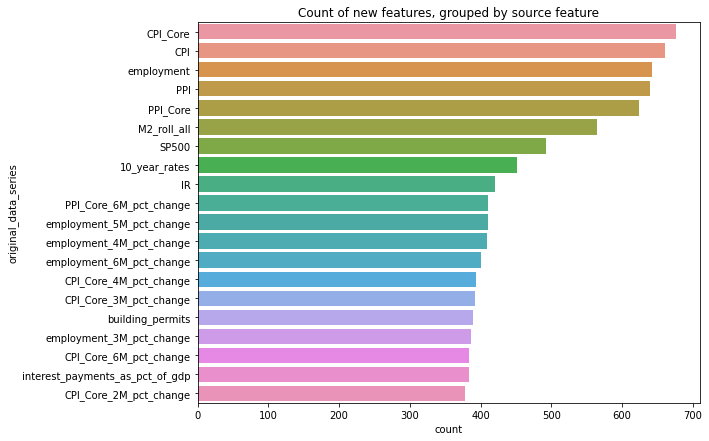

In [29]:
plt.figure(figsize=(9,7))
g = sns.countplot(y = original_data_series_series,
              order = original_data_series_series.value_counts()[:20].index)
g.set(title='Count of new features, grouped by source feature')

# Explain plot
print(f'''The plot shows that 
{original_data_series_series.value_counts().index[0]}, 
{original_data_series_series.value_counts().index[1]}, and 
{original_data_series_series.value_counts().index[2]} 
are the most useful source features, as 
these features generated about 
{round(100*original_data_series_series.value_counts()[:3].sum()/num_new_features)}% of the useful features.''')

Surprisingly, the gdp nowcast, an indicator that is designed to forecast the next GDP news release, is not found to be useful by" the feature selection algorithm.

The plot shows that 
fft_coefficient, 
change_quantiles, and 
agg_linear_trend 
are the most useful feature generation calculations, as these caluclations
generated about 55% of the useful features.


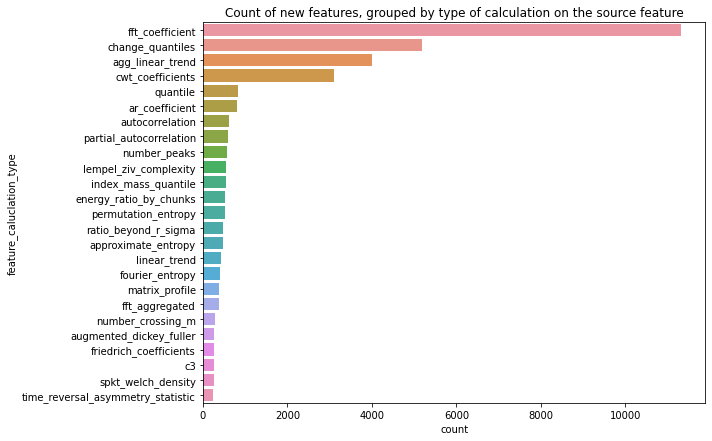

In [30]:
plt.figure(figsize=(9,7))
g = sns.countplot(y = feature_caluclation_type_series,
              order = feature_caluclation_type_series.value_counts()[:25].index)
g.set(title='Count of new features, grouped by type of calculation on the source feature')

# Explain plot
print(f'''The plot shows that 
{feature_caluclation_type_series.value_counts().index[0]}, 
{feature_caluclation_type_series.value_counts().index[1]}, and 
{feature_caluclation_type_series.value_counts().index[2]} 
are the most useful feature generation calculations, as these caluclations
generated about {round(100*feature_caluclation_type_series.value_counts()[:3].sum()/num_new_features)}% of the useful features.''')

# Trade-off between length of training period, and number of available data sources

Ideally, we'd like to train the model with all the data over the longest period possible. However, some data series are fairly new--less than 10 year old--while others have quite a long history spanning multiple decades. 

interest_payments_as_pct_of_gdp           1947-04-01
liquidity_cover_ratio                     1947-04-01
weekly_hours                              1947-04-01
CPI                                       1947-04-01
employment                                1947-04-01
PPI                                       1947-04-01
SP500                                     1947-04-06
surplus_or_deficit_as_pct_of_gdp          1947-06-30
PMI_deliv                                 1948-01-01
PMI_new_orders                            1948-01-01
PMI                                       1948-01-01
michigan_consumer_sentiment               1952-11-01
IR                                        1954-07-01
CPI_Core                                  1957-01-01
building_permits                          1960-01-01
10_year_rates                             1962-01-05
IR_spread                                 1962-01-07
debt_as_pct_of_gdp                        1966-01-01
initial_claims                            1967

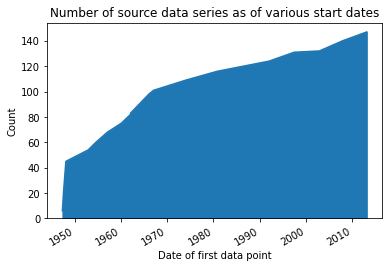

In [31]:
first_valid_loc = df[unprocessed_subset] \
                    .apply(lambda col: col.first_valid_index())
start_dates =  pd.Index(first_valid_loc.sort_values().unique())

num_of_notna = pd.Series(dtype=object)
for start_date in start_dates:
  num_of_notna[start_date] = len(df.drop(columns=['gdp_growth', 'is_recession'])
                                   .fillna(method='ffill')
                                   .loc[start_date:]
                                   .dropna(axis=1).columns)

unique_start_dates = sorted(list(set(first_valid_loc)))

# Plot Number of available data series from various start dates
num_of_notna.plot.area()
plt.xlabel('Date of first data point')
plt.ylabel('Count')
plt.title('Number of source data series as of various start dates')

first_valid_loc.sort_values()

  0%|          | 0/6 [00:00<?, ?it/s]

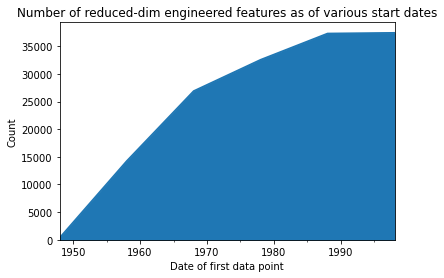

In [32]:
# Number of reduced dimension extracted features as of various start dates.

first_valid_loc = reduced_dim_features \
                    .apply(lambda col: col.first_valid_index())
start_dates =  pd.Index(first_valid_loc.sort_values().unique())
start_dates.year
num_of_notna = pd.Series(dtype=object)

for start_date in tqdm(pd.date_range('1948', start_dates[-1], freq='AS')[::10]):
  num_of_notna[start_date] = len(reduced_dim_features.fillna(method='ffill').loc[start_date:]
                                   .dropna(axis=1).columns)

unique_start_dates = sorted(list(set(first_valid_loc)))

# Plot Number of available data series from various start dates
num_of_notna.plot.area()
plt.xlabel('Date of first data point')
plt.ylabel('Count')
plt.title('Number of reduced-dim engineered features as of various start dates')
plt.show()

We will address this trade-off by cross-validating baseline models on slices of the training data with various start dates. Longer training periods (starting earlier) will have fewer sources data series, while shorter training peroids (starting later) will have access to more source data series. 

It will be interesting to see if the few long-running data series are more useful than abundance of newly-introduced data series when predicting the GDP. 

## Modeling the various training start dates

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Cache reused transformers
from tempfile import mkdtemp
from shutil import rmtree

cachedir = mkdtemp()
# Clear the cache directory when you don't need it anymore
# rmtree(cachedir)


In [34]:

# features_df = reduced_dim_features 
# target_series = df['gdp_growth']

# n_splits= 10
# test_size= 1

# tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# cv_results = []

# # Sample various start dates, 10 years apart
# for train_start_date in tqdm(pd.date_range('1958', '2008', freq='AS')[::10], desc='train_start_dates'):
#   # print(f'\ntraining start_date:\t{train_start_date}')
#   Xy = df['gdp_growth'][train_start_date:].dropna().to_frame().join(reduced_dim_features.fillna(method='ffill')).loc[train_start_date:, :]
#   Xy = Xy.dropna(axis=1).dropna().dropna()
#   print(train_start_date, Xy.shape)
#   y = Xy.pop('gdp_growth')
#   X = Xy

#   # X = features_df.loc[train_start_date:]
#   # y = target_series.loc[train_start_date:]
#   # try:
#   pred_series = pd.Series(dtype=float, name='pred')
#   for train_ilocs, test_ilocs in tscv.split(X):
#     # Convert iloc to date index
#     train_indices = X.iloc[train_ilocs,:].index
#     test_indices = X.iloc[test_ilocs,:].index

#     # Make train test splits
#     X_train = X.loc[train_indices,:]
#     X_test = X.loc[test_indices,:]
#     y_train = y[train_indices]
#     y_test = y[test_indices]
#     # print( X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#     impute(X_train)
#     impute(X_test)

#     forecast_date = test_indices
#     # y_true[forecast_date] = y[forecast_date] 
#     # print(f'forecast_date: {forecast_date}')
    
#     pipeline = Pipeline([('drop_constant_features', VarianceThreshold()),
#                          ('scaler', StandardScaler()),
#                          ('feature_selector', SelectPercentile()),
#                          ('regressor', DummyRegressor())],
#                         memory=cachedir)
#     param_grid = {'feature_selector__percentile': [1, 2, 5],
#                   'regressor': [DummyRegressor(strategy='mean'),
#                                 DummyRegressor(strategy='median'),
#                                 DecisionTreeRegressor(),
#                                 RandomForestRegressor(),
#                                 GradientBoostingRegressor(),
#                                 ElasticNet()
#                                 ]}
                        
#     gs = GridSearchCV(pipeline, param_grid, cv=TimeSeriesSplit(n_splits=3, test_size=3), scoring='neg_mean_absolute_error')
#     # regressor.set_params(params)
#     gs.fit(X_train.values, y_train.values)
#     cv_df = pd.DataFrame(gs.cv_results_)
#     cv_df['train_start_date'] = train_start_date
#     cv_df['forecast_date'] = test_indices.item()
#     cv_results.append(cv_df)

# cv_df = pd.concat(cv_results)

# # Save cv_results
# with open(working_path/'models/cv_results_various_start_dates.pkl.gzip', 'wb') as f:
#   cv_df.to_pickle(f)

In [35]:
# Load cv_results
with open(working_path/'models/cv_results_various_start_dates.pkl.gzip', 'rb') as f:
  cv_df = pickle.load(f)
                    
cv_df['param_feature_selector__percentile'] = cv_df['param_feature_selector__percentile'].astype('category')
cv_df['param_regressor'] = cv_df['param_regressor'].astype('string').astype('category')
# cv_df['params'] = cv_df['params'].astype('category')
cv_df['forecast_date'] = cv_df['forecast_date'].astype('category')

cv_df.dtypes

mean_fit_time                                float64
std_fit_time                                 float64
mean_score_time                              float64
std_score_time                               float64
param_feature_selector__percentile          category
param_regressor                             category
params                                        object
split0_test_score                            float64
split1_test_score                            float64
split2_test_score                            float64
mean_test_score                              float64
std_test_score                               float64
rank_test_score                                int32
train_start_date                      datetime64[ns]
forecast_date                               category
dtype: object

Let's explore the grid search results to find the best models, the best start dates, and the most important parameters.

Text(0.5, 1.0, 'Forecast Error (negative MAE) of baseline models at all start dates')

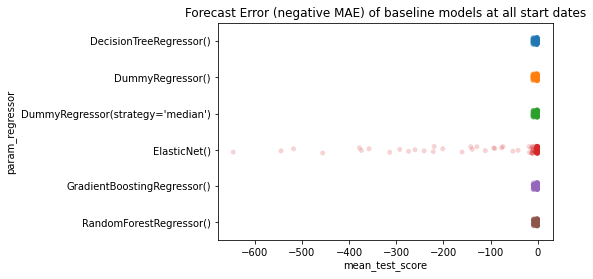

In [36]:
sns.stripplot(data=cv_df,
            y='param_regressor',
            x='mean_test_score',
            alpha=0.2)
plt.title('Forecast Error (negative MAE) of baseline models at all start dates')

Clearly ElasticNet is skewing the results. Let's drop ElasticNet for now.

In [37]:
cv_df = cv_df[cv_df['param_regressor']!='ElasticNet()']
cv_df['param_regressor'] = cv_df['param_regressor'].astype('string').astype('category')

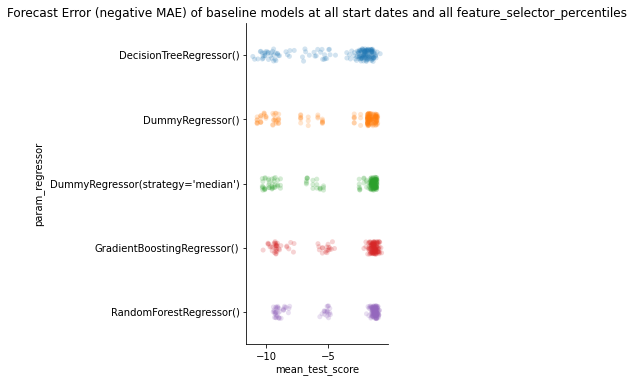

In [38]:
sns.catplot(data=cv_df,
            x='mean_test_score',
            y='param_regressor',
            alpha=0.2)
plt.title('Forecast Error (negative MAE) of baseline models at all start dates and all feature_selector_percentiles');

Surprisingly, the DummyRegressor('median') is not that bad at making out-of-sample predictions. Let's divide the plots by it's categories to get a closer look and the effect of the feature selector percentiles and train start date. It will be interesting to see if any one parameter explains the three obvious clusters on each model.

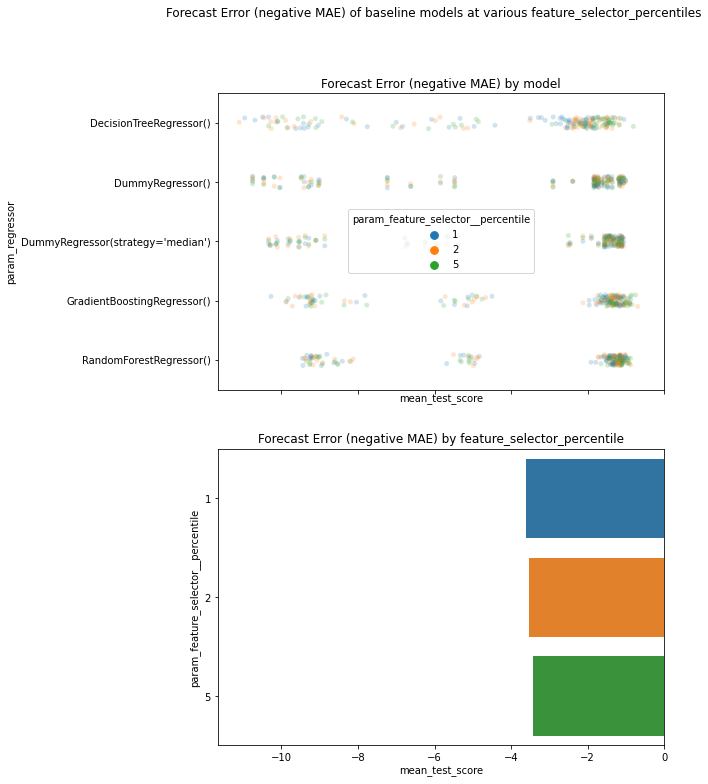

In [39]:
fig, ax = plt.subplots(2,1, figsize=(8,12), sharex=True)
g = sns.stripplot(data=cv_df,
            x='mean_test_score',
            y='param_regressor',
            hue='param_feature_selector__percentile',
            alpha=0.2, ax=ax[0])
g.set(title='Forecast Error (negative MAE) by model')

cv_df_by_by_selector_percentile = cv_df.groupby('param_feature_selector__percentile').mean().reset_index()
cv_df_by_by_selector_percentile['param_feature_selector__percentile'] = cv_df_by_by_selector_percentile['param_feature_selector__percentile'].astype('category')
g = sns.barplot(data=cv_df_by_by_selector_percentile,
            x='mean_test_score',
            y='param_feature_selector__percentile', ax=ax[1])
g.set(title='Forecast Error (negative MAE) by feature_selector_percentile')
plt.suptitle('Forecast Error (negative MAE) of baseline models at various feature_selector_percentiles')
plt.show()

`param_feature_selector__percentile` doesn't explain the clusters

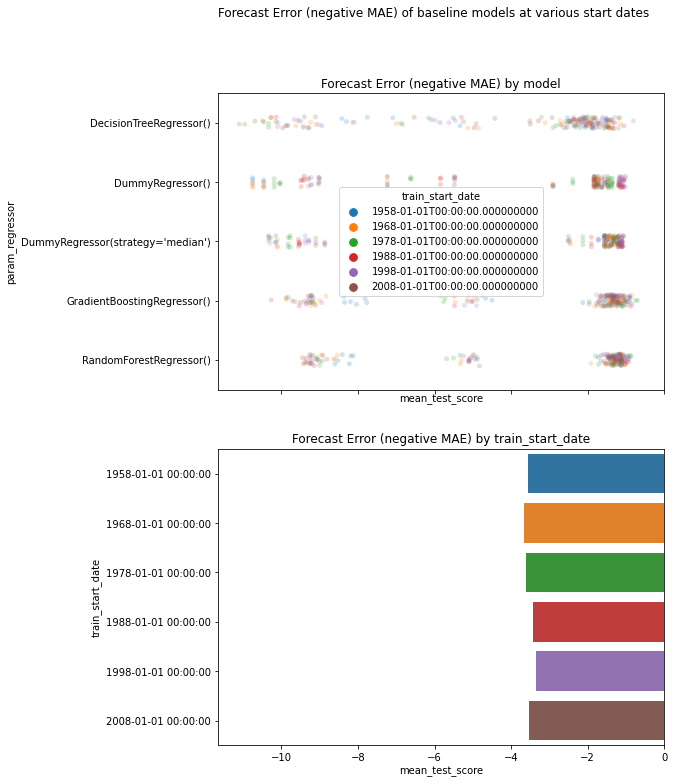

In [40]:
fig, ax = plt.subplots(2,1, figsize=(8,12), sharex=True)
g = sns.stripplot(data=cv_df,
            x='mean_test_score',
            y='param_regressor',
            hue='train_start_date', 
            alpha=0.2, ax=ax[0])
g.set(title='Forecast Error (negative MAE) by model')

cv_df_by_start_date = cv_df.groupby('train_start_date').mean().reset_index()
cv_df_by_start_date['train_start_date'] = cv_df_by_start_date['train_start_date'].astype('category')
g = sns.barplot(data=cv_df_by_start_date,
            x='mean_test_score',
            y='train_start_date', ax=ax[1])
g.set(title='Forecast Error (negative MAE) by train_start_date')

plt.suptitle('Forecast Error (negative MAE) of baseline models at various start dates')
plt.show()

`train_start_date` doesn't explain the clusters either.

As train_start_date does not seem to make a difference, going forward, we will only select 1990 as the date to start training, as that is the date where the number of engineered features also seems to plateau.

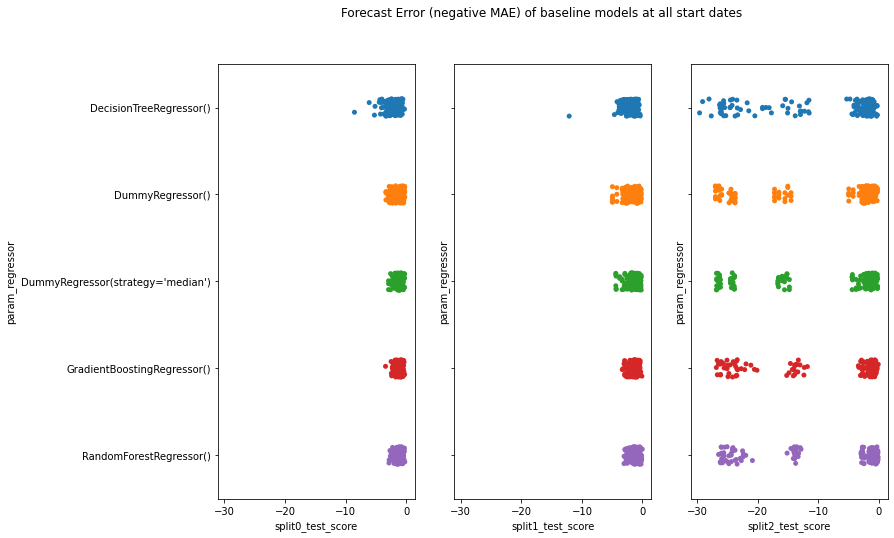

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(12,8), sharey=True, sharex=True)
sns.stripplot(data=cv_df,
            x='split0_test_score',
            y='param_regressor', ax=ax[0])
sns.stripplot(data=cv_df,
            x='split1_test_score',
            y='param_regressor', ax=ax[1])
sns.stripplot(data=cv_df,
            x='split2_test_score',
            y='param_regressor', ax=ax[2])

plt.suptitle('Forecast Error (negative MAE) of baseline models at all start dates')
plt.show()

Split0 is the out-of-sample forecast one period ahead of the train data. Split1 is the out-of-sample forecast two periods ahead of the train data and Split2 is the forecast three periods ahead of the train data.

From the three strip plots, we can see that all the models forecast well on the first two periods after the train data, and all models forecast much worse on the third period after the train data.

Going forward, we will score models on the first two periods after training only.

# Modelling

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.selection import SmartCorrelatedSelection

# Make a custom trasnsformer that performs more effieceintly on large dataframes than basee SmartCorrelatedSelection
class FastSmartCorrelatedSelection(SmartCorrelatedSelection):
  """
  SmartCorrelatedSelection() finds groups of correlated features and then selects,
  from each group, a feature following certain criteria:
  - Feature with least missing values
  - Feature with most unique values
  - Feature with highest variance
  - Best performing feature according to estimator entered by user
  SmartCorrelatedSelection() returns a dataframe containing from each group of
  correlated features, the selected variable, plus all original features that were
  not correlated to any other.
  Correlation is calculated with `pandas.corr()`.
  SmartCorrelatedSelection() works only with numerical variables. Categorical
  variables will need to be encoded to numerical or will be excluded from the
  analysis.
  Parameters
  ----------
  variables: list, default=None
      The list of variables to evaluate. If None, the transformer will evaluate all
      numerical variables in the dataset.
  method: string, default='pearson'
      Can take 'pearson', 'spearman' or'kendall'. It refers to the correlation method
      to be used to identify the correlated features.
      - pearson : standard correlation coefficient
      - kendall : Kendall Tau correlation coefficient
      - spearman : Spearman rank correlation
  threshold: float, default=0.8
      The correlation threshold above which a feature will be deemed correlated with
      another one and removed from the dataset.
  missing_values: str, default=ignore
      Takes values 'raise' and 'ignore'. Whether the missing values should be raised
      as error or ignored when determining correlation.
  selection_method: str, default= "missing_values"
      Takes the values "missing_values", "cardinality", "variance" and
      "model_performance".
      "missing_values": keeps the feature from the correlated group with least
      missing observations
      "cardinality": keeps the feature from the correlated group with the highest
      cardinality.
      "variance": keeps the feature from the correlated group with the highest
      variance.
      "model_performance": trains a machine learning model using the correlated
      feature group and retains the feature with the highest importance.
  estimator: object, default = None
      A Scikit-learn estimator for regression or classification.
  scoring: str, default='roc_auc'
      Desired metric to optimise the performance of the estimator. Comes from
      sklearn.metrics. See the model evaluation documentation for more options:
      https://scikit-learn.org/stable/modules/model_evaluation.html
  cv: int, cross-validation generator or an iterable, default=3
      Determines the cross-validation splitting strategy. Possible inputs for cv are:
          - None, to use cross_validate's default 5-fold cross validation
          - int, to specify the number of folds in a (Stratified)KFold,
          - CV splitter
              - (https://scikit-learn.org/stable/glossary.html#term-CV-splitter)
          - An iterable yielding (train, test) splits as arrays of indices.
      For int/None inputs, if the estimator is a classifier and y is either binary or
      multiclass, StratifiedKFold is used. In all other cases, Fold is used. These
      splitters are instantiated with shuffle=False so the splits will be the same
      across calls.
      For more details check Scikit-learn's cross_validate documentation
  Attributes
  ----------
  correlated_feature_sets_:
      Groups of correlated features.  Each list is a group of correlated features.
  features_to_drop_:
      The correlated features to remove from the dataset.
  variables_:
      The variables to consider for the feature selection.
  n_features_in_:
      The number of features in the train set used in fit.
  Methods
  -------
  fit:
      Find best feature from each correlated groups.
  transform:
      Return selected features.
  fit_transform:
      Fit to the data. Then transform it.
  See Also
  --------
  pandas.corr
  feature_engine.selection.DropCorrelatedFeatures
  """

  def fit_transform(self, X: pd.DataFrame, y: pd.Series = None):
    """
    Find the correlated feature groups. Determine which feature should be selected
    from each group.
    Parameters
    ----------
    X: pandas dataframe of shape = [n_samples, n_features]
        The training dataset.
    y: pandas series. Default = None
        y is needed if selection_method == 'model_performance'.
    Returns
    -------
    self
    """
    def chunk_SmartCorrelatedSelection(X, n_chunks=10, **kwargs):
      #Drop highly correlated features, except one
      # print('X.shape before rough_SmartCorrelatedSelection:', X.shape)
      
      # set up the selector
      tr = SmartCorrelatedSelection(
          variables=self.variables,
          method=self.method,
          threshold=self.threshold,
          missing_values=self.missing_values,
          selection_method=self.selection_method,
          estimator=self.estimator
      )
      
      if n_chunks not in [None, 0, 1, 2, 3, 4]:
        # Get the low corr df by chunking the large df into smaller ones

        # Shuffle the order column names
        col_names = list(X.columns)
        # Shuffle names in place
        np.random.default_rng().shuffle(col_names)
        
        # Make n_chunks groups of col names
        shuffled_col_names_lists = []
        for i in np.array_split(col_names, n_chunks):
          shuffled_col_names_lists.append(list(i))

        # get the low corr small dfs
        acc = []
        for col_name_list in shuffled_col_names_lists:
          acc.append(tr.fit_transform(X[col_name_list]))

        # join small dfs
        low_corr_X = pd.concat(acc, axis=1)
        # print('X.shape after rough_SmartCorrelatedSelection:', low_corr_X.shape)
        return low_corr_X
      else:
        low_corr_X = tr.fit_transform(X)
        return low_corr_X

    n_chunks_min = 4
    if  X.shape[1] <= n_chunks_min:
      return chunk_SmartCorrelatedSelection(X, n_chunks=None)
    else:
      n_chunks = int(10**(np.log10(X.shape[1])-1))
      print(f'n_chunks: {n_chunks}')
    
    prev_len = X.shape[1]
    while n_chunks >= n_chunks_min:
      X = chunk_SmartCorrelatedSelection(X, n_chunks=n_chunks)
      cur_len = X.shape[1]
      improvement = 1-cur_len/prev_len
      ic(cur_len, prev_len, improvement)
      # print(f'cur_len: {cur_len}, prev_len: {prev_len}, improvement: {improvement}')
      prev_len = cur_len
      n_chunks = n_chunks if improvement>0.25 else int(n_chunks / 4)
      print(f'n_chunks: {n_chunks}')
    print(f'Can\'t decrease n_chunks any further: n_chunks={n_chunks}')
    print('final iteration with full dataframe')
    return chunk_SmartCorrelatedSelection(X, n_chunks=None)



In [43]:
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures

# Make X and y
Xy = df['gdp_growth'].to_frame().dropna().join(reduced_dim_features.fillna(method='ffill')).loc['2005':,:]
y = Xy.pop('gdp_growth')
X = Xy
impute(X)
X = DropConstantFeatures().fit_transform(X)
X = FastSmartCorrelatedSelection(threshold=0.6).fit_transform(X)
print(X.shape, y.shape)

# set up the selector
tr = FastSmartCorrelatedSelection()

print('X.shape before FastSmartCorrelatedSelection:', X.shape)
X = tr.fit_transform(X)
print('X.shape after FastSmartCorrelatedSelection:', X.shape)

n_chunks: 3679


ic| cur_len: 23427, prev_len: 36796, improvement: 0.36332753560169584


n_chunks: 3679


ic| cur_len: 20351, prev_len: 23427, improvement: 0.13130148973406752


n_chunks: 919


ic| cur_len: 15409, prev_len: 20351, improvement: 0.24283818976954452


n_chunks: 229


ic| cur_len: 11081, prev_len: 15409, improvement: 0.2808748134207282


n_chunks: 229


ic| cur_len: 9620, prev_len: 11081, improvement: 0.13184730619980145


n_chunks: 57


ic| cur_len: 7387, prev_len: 9620, improvement: 0.23212058212058218


n_chunks: 14


ic| cur_len: 5146, prev_len: 7387, improvement: 0.3033707865168539


n_chunks: 14


ic| cur_len: 4259, prev_len: 5146, improvement: 0.1723668869024485


n_chunks: 3
Can't decrease n_chunks any further: n_chunks=3
final iteration with full dataframe
(65, 1953) (65,)
X.shape before FastSmartCorrelatedSelection: (65, 1953)
n_chunks: 195


ic| cur_len: 1953, prev_len: 1953, improvement: 0.0


n_chunks: 48


ic| cur_len: 1952, prev_len: 1953, improvement: 0.0005120327700972593


n_chunks: 12


ic| cur_len: 1952, prev_len: 1952, improvement: 0.0


n_chunks: 3
Can't decrease n_chunks any further: n_chunks=3
final iteration with full dataframe
X.shape after FastSmartCorrelatedSelection: (65, 1911)


In [44]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import HalvingGridSearchCV

In [45]:
# Prepare gridsearch params
pipeline = Pipeline([ 
                     ('scaler', StandardScaler()),
                     # ('feature_selector', SelectPercentile(percentile=0.5)),
                     ('regressor', HistGradientBoostingRegressor())],
                       memory=cachedir)
param_grid = [
              { 'regressor': [DummyRegressor()],
                'regressor__strategy': ['median']},
              { 'regressor': [DecisionTreeRegressor()],
                'regressor__max_depth': [10, 20, 50, 100, 250, 1000]},
              { 'regressor': [RandomForestRegressor()],
                'regressor__n_estimators': [100, 200, 400, 800],
                'regressor__max_depth': [5, 10, 20, 40, 80]},
              { 'regressor': [HistGradientBoostingRegressor()],
                'regressor__learning_rate': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
                'regressor__max_iter': [50, 100, 200, 400, 800]},
              { 'regressor': [SVR()],
                'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'regressor__C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
                'regressor__epsilon': [0.01, 0.1, 1, 5, 10]},
             ]

tscv = TimeSeriesSplit(n_splits=24, test_size=2)

gs = GridSearchCV(pipeline, param_grid, 
                         cv=tscv, 
                         scoring='neg_mean_absolute_error', verbose=1)

In [46]:
# # Run gridsearch
# gs.fit(X, y)

# # Save gs_results
# with open(working_path/'models/gs_results_baseline.pkl.gzip', 'wb') as f:
#   pickle.dump(gs, f)

In [47]:
# Load gs object
with open(working_path/'models/gs_results_baseline.pkl.gzip', 'rb') as f:
  gs = pickle.load(f)

cv_results = pd.DataFrame(gs.cv_results_).dropna(axis=1)
cv_results['param_regressor'] = cv_results['param_regressor'].astype('string').astype('category')
# cv_results['params'] = cv_results['params'].astype('category')
                    
# cv_results['param_feature_selector__percentile'] = cv_results['param_feature_selector__percentile'].astype('category')
# cv_results['forecast_date'] = cv_results['forecast_date'].astype('category')

cv_results['mean_test_score'] = cv_results.filter(regex=r'split\d+_test_score').mean(axis=1)
cv_results['std_test_score'] =  cv_results.filter(regex=r'split\d+_test_score').std(axis=1)
cv_results['params_as_str'] = cv_results['params'].astype('string')
cv_results.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,mean_test_score,std_test_score,rank_test_score,params_as_str
177,0.025672,0.002007,0.015255,0.000770,SVR(),"{'regressor': SVR(), 'regressor__C': 10, 'regr...",-1.332316,-2.96183,-3.569661,-1.831616,-3.265711,-4.574641,-1.943965,-5.357036,-5.626381,-2.6,-6.006744,-1.481486,-2.252757,-0.508755,-2.131669,-2.651636,-2.100232,-4.596429,-3.058958,-1.974517,-2.463111,-3.737498,-35.073407,-4.148016,-4.385349,6.688549,107,"{'regressor': SVR(), 'regressor__C': 10, 'regr..."
178,0.025614,0.001834,0.015159,0.000404,SVR(),"{'regressor': SVR(), 'regressor__C': 10, 'regr...",-1.550000,-3.65000,-4.350000,-2.150000,-3.450000,-5.000000,-2.350000,-3.300000,-2.850000,-2.6,-6.750000,-2.600000,-3.250000,-0.750000,-3.250000,-3.900000,-3.400000,-5.850000,-4.450000,-3.050000,-3.450000,-3.650000,-35.550000,-6.487174,-4.901549,6.679240,120,"{'regressor': SVR(), 'regressor__C': 10, 'regr..."
179,0.025551,0.001780,0.015082,0.000222,SVR(),"{'regressor': SVR(), 'regressor__C': 10, 'regr...",-1.550000,-3.65000,-4.350000,-2.150000,-3.450000,-5.000000,-2.350000,-3.300000,-2.850000,-2.6,-6.750000,-2.600000,-3.250000,-0.750000,-3.250000,-3.900000,-3.400000,-5.850000,-4.450000,-3.050000,-3.450000,-3.650000,-35.550000,-7.565531,-4.946480,6.693981,127,"{'regressor': SVR(), 'regressor__C': 10, 'regr..."
180,0.025301,0.001477,0.015016,0.000411,SVR(),"{'regressor': SVR(), 'regressor__C': 10, 'regr...",-1.550000,-3.65000,-4.350000,-2.150000,-3.450000,-5.000000,-2.350000,-3.300000,-2.850000,-2.6,-6.750000,-2.600000,-3.250000,-0.750000,-3.250000,-3.900000,-3.400000,-5.850000,-4.450000,-3.050000,-3.450000,-3.650000,-35.550000,-7.624406,-4.948934,6.694993,128,"{'regressor': SVR(), 'regressor__C': 10, 'regr..."
181,0.025326,0.001482,0.014961,0.000180,SVR(),"{'regressor': SVR(), 'regressor__C': 10, 'regr...",-1.550000,-3.65000,-4.350000,-2.150000,-3.450000,-5.000000,-2.350000,-3.300000,-2.850000,-2.6,-6.750000,-2.600000,-3.250000,-0.750000,-3.250000,-3.900000,-3.400000,-5.850000,-4.450000,-3.050000,-3.450000,-3.650000,-35.550000,-4.410339,-4.815014,6.671252,116,"{'regressor': SVR(), 'regressor__C': 10, 'regr..."


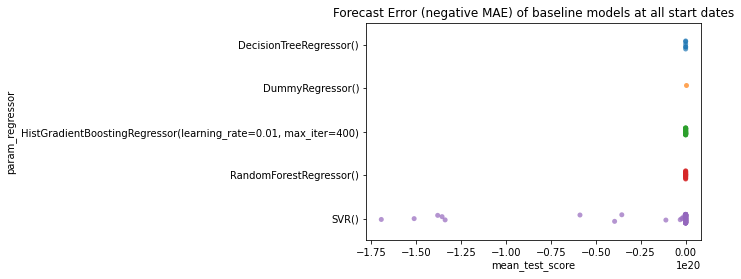

In [48]:
sns.stripplot(data=cv_results,
            x='mean_test_score',
            y='param_regressor',
            alpha=0.7)
plt.title('Forecast Error (negative MAE) of baseline models at all start dates');

Again, the SGD regressor (SVR) is skewing the plot. Let's view the plot without the SGD regressor.

In [76]:
cv_results = cv_results[cv_results['param_regressor'].astype('string')!="SVR()"]
cv_results['param_regressor'] = cv_results['param_regressor'].astype('string').astype('category') 

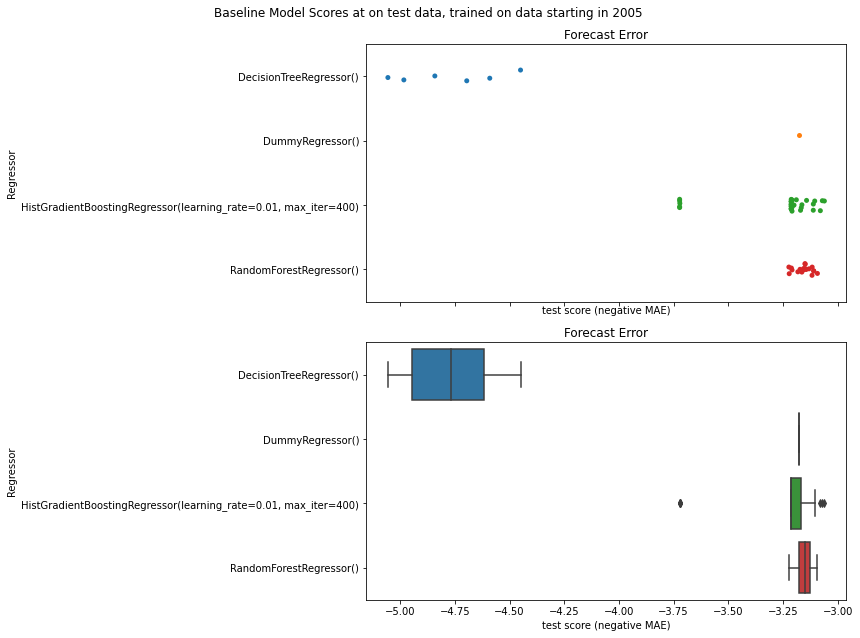

In [84]:
# Plot results with SVR (SVD)
fig, ax = plt.subplots(2, 1, figsize=(12,9), sharex=True)
g = sns.stripplot(data=cv_results,
              y='param_regressor',
              x='mean_test_score',
              ax=ax[0])
g.set(xlabel='test score (negative MAE)',
      ylabel='Regressor',
      title='Forecast Error')

g = sns.boxplot(data=cv_results,
# g = sns.boxplot(data=cv_results.groupby('param_regressor').mean().reset_index(),
              y='param_regressor',
              x='mean_test_score',
              ax=ax[1],)
g.set(xlabel='test score (negative MAE)',
      ylabel='Regressor',
      title='Forecast Error')

fig.suptitle('Baseline Model Scores at on test data, trained on data starting in 2005')
plt.tight_layout()

Surprisingly, after the Dummy Regressor (strategy='median') is a fairly high=scoring regressor.

The ensemble methods (gradient bossting and random forest) are both pretty good too.